# 07. Integrated Prophet Analysis: Rolling Ensemble System

---

## 아키텍처

```
Data Loader -> Feature Engineering (RSI, MA 등)
  ↓
[Rolling Loop: 2021..2025]
  ↓
Train (Prophet + XGBoost Residual)
  ↓
Predict (Hybrid: Prophet + XGB Correction with Alpha Weight)
  ↓
Scenario Adjustment (Bull/Neutral/Bear in log-space)
  ↓
Evaluation (MAPE, Spearman, Top-K Hit Rate)
```

## 핵심 설계 원칙

### Rule 1) 통일된 데이터 포맷

### Rule 2) 타겟 y는 log(Sector_Index)
섹터별 일간 평균 수익률 -> 지수 생성 (Base=100) -> log 변환

### Rule 3) Rolling Loop에서 스케일러 재학습
매년 루프에서 train만 가지고 scaler fit, test는 transform만 (데이터 누수 방지)

### Rule 4) 앙상블은 잔차 방식 + Alpha 가중치
1. Prophet으로 yhat_prophet 생성
2. resid = y - yhat_prophet (train 구간)
3. XGBoost로 resid 예측
4. **yhat_hybrid = alpha * yhat_prophet + (1-alpha) * (yhat_prophet + resid_hat)**

### Rule 5) Scenario는 예측 후 적용 (log-space)
시나리오 분류는 train_end까지의 정보만 사용
**log-space 보정**: yhat_final = yhat_hybrid_h + log(scenario_adj)

### Rule 6) 평가는 랭킹 중심
- MAPE/RMSE/MAE: 참고
- **핵심**: Spearman Rank Correlation, Top-3/5 Hit Rate, 근접성공(|rank diff|≤2)

### Rule 7) Alpha 튜닝 (Grid Search) + 2023 제외
- alpha 후보별로 Rolling Loop 실행
- 2023년 제외하고 성능 평가 (exclude_years=(2023,))
- avg_top5 1순위, avg_spearman 2순위로 최적 alpha 선정

---

## Section 1. 환경 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import os
from prophet import Prophet
import xgboost as xgb

# 미국 공휴일
import holidays

from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

warnings.filterwarnings('ignore')

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# 한글 폰트
import koreanize_matplotlib
pkg_dir = os.path.dirname(koreanize_matplotlib.__file__)
font_path = os.path.join(pkg_dir, 'fonts', 'NanumGothic.ttf')

fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"Font: {font_name}")

Font: NanumGothic


In [2]:
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'Data_set'
OUTPUT_DIR = DATA_DIR / 'Integrated_Prophet_Results'
TABLEAU_DIR = DATA_DIR / 'Tableau_Csv'

OUTPUT_DIR.mkdir(exist_ok=True)

print(f"프로젝트 경로: {PROJECT_ROOT}")
print(f"결과 저장: {OUTPUT_DIR}")

프로젝트 경로: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance
결과 저장: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance/Data_set/Integrated_Prophet_Results


---

## Section 2. 데이터 로드 및 섹터 인덱스 생성

### 2.1 원본 데이터 로드

In [3]:
print("=" * 60)
print("데이터 로드")
print("=" * 60)

df = pd.read_csv(DATA_DIR / 'stock_features_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 결측치 및 Unknown 섹터 제거
df = df.dropna(subset=['Date', 'Close', 'Sector', 'Daily_Return'])
df = df[df['Sector'] != 'Unknown']

print(f"\n로드 완료")
print(f"  Shape: {df.shape}")
print(f"  기간: {df['Date'].min().date()} ~ {df['Date'].max().date()}")
print(f"  기업 수: {df['Company'].nunique()}")
print(f"  섹터 수: {df['Sector'].nunique()}")

# 섹터 목록
print("\n섹터 목록:")
sector_counts = df.groupby('Sector')['Company'].nunique().sort_values(ascending=False)
for i, (sector, count) in enumerate(sector_counts.items(), 1):
    print(f"  {i:2d}. {sector} ({count}개 기업)")

데이터 로드

로드 완료
  Shape: (603359, 41)
  기간: 2020-11-27 ~ 2026-01-09
  기업 수: 481
  섹터 수: 11

섹터 목록:
   1. Financial Services (82개 기업)
   2. Technology (77개 기업)
   3. Healthcare (56개 기업)
   4. Industrials (56개 기업)
   5. Consumer Cyclical (45개 기업)
   6. Energy (38개 기업)
   7. Consumer Defensive (31개 기업)
   8. Communication Services (27개 기업)
   9. Basic Materials (26개 기업)
  10. Utilities (24개 기업)
  11. Real Estate (19개 기업)


### 2.2 섹터 인덱스 생성 (수익률 기반)

**계산 방식**:
1. 섹터 내 모든 종목의 일간 수익률 평균 계산
2. 이를 100에서 시작하는 누적 지수로 환산

**장점**: 
- 고가 주식 편향 제거
- Prophet이 선형 추세 잘 포착
- XGBoost 잔차 모델도 안정적

In [4]:
def calculate_sector_index_log(df):
    """
    수익률 기반 섹터 인덱스 계산 (Vectorized & Log Consistency)
    """
    df_clean = df.copy()

    #  1. 이상치 클리핑
    # 개별 종목의 수익률이 상위 1% / 하위 1%를 벗어나면 경계값으로 치환
    upper_limit = df_clean['Daily_Return'].quantile(0.99)
    lower_limit = df_clean['Daily_Return'].quantile(0.01)
    
    # 예: 상위 1%가 +25%라면, +50%인 종목을 +25%로 깎음
    df_clean['Daily_Return'] = df_clean['Daily_Return'].clip(lower=lower_limit, upper=upper_limit)

    # 2. 섹터/일자별 집계
    sector_daily = df_clean.groupby(['Date', 'Sector'], as_index=False).agg({
        'Daily_Return': 'mean',
        'Volume': 'sum',
        'Company': 'count'
    })
    
    # 날짜순 정렬
    sector_daily = sector_daily.sort_values(['Sector', 'Date'])
    
    # 결측치 처리
    sector_daily['Daily_Return'] = sector_daily['Daily_Return'].fillna(0)
    
    # 3. 지수 계산
    # 각 섹터별로 (1+r)의 누적곱 계산
    sector_daily['Index'] = sector_daily.groupby('Sector')['Daily_Return'].transform(
        lambda x: 100 * (1 + x).cumprod()
    )
    
    # 4. 로그 변환
    sector_daily['y'] = np.log(sector_daily['Index'])
    
    # Prophet 입력용 컬럼
    sector_daily['ds'] = sector_daily['Date']
    
    return sector_daily

# 실행
sector_df = calculate_sector_index_log(df)

print(f"\n섹터 인덱스 생성 완료: {sector_df.shape}")
print(f"컬럼: {sector_df.columns.tolist()}")
print(f"\n샘플 데이터:")
print(sector_df.head(10))


섹터 인덱스 생성 완료: (14135, 8)
컬럼: ['Date', 'Sector', 'Daily_Return', 'Volume', 'Company', 'Index', 'y', 'ds']

샘플 데이터:
         Date           Sector  Daily_Return     Volume  Company       Index  \
0  2020-11-27  Basic Materials      0.003054   68568783       24  100.305401   
11 2020-11-30  Basic Materials     -0.009052  132420442       24   99.397448   
22 2020-12-01  Basic Materials      0.022079  126777499       24  101.592009   
33 2020-12-02  Basic Materials     -0.000330  123427550       24  101.558435   
44 2020-12-03  Basic Materials      0.003853  107596029       24  101.949698   
55 2020-12-04  Basic Materials      0.019749  127260672       24  103.963087   
66 2020-12-07  Basic Materials     -0.000743  105091051       24  103.885852   
77 2020-12-08  Basic Materials      0.003298   82921991       24  104.228511   
88 2020-12-09  Basic Materials     -0.005910   87466621       24  103.612512   
99 2020-12-10  Basic Materials     -0.001343  101516656       24  103.473313   

    

---

## Section 3. Feature Engineering (기술적 지표)

### 3.1 기술적 지표 계산

**Prophet 외부 변수로 사용할 기술적 지표**:
- **RSI_14**: 상대강도지수 (과매수/과매도)
- **Volatility_20d**: 20일 변동성
- **BB_Width**: 볼린저 밴드 폭 (변동성 스퀴즈)
- **Vol_Z_Score**: 거래량 Z-Score
- **Gap_Pct**: 전일 대비 갭 비율

In [5]:
import pandas as pd
import numpy as np

def build_sector_panel_from_stock_df(
    df: pd.DataFrame,
    sector_index_df: pd.DataFrame,
    key_columns: list,
    *,
    # 집계/가공 옵션
    mean_cols: list | None = None,
    risk_cols_q80: list | None = None,
    vol_z_q90_col: str = "Vol_Z_Score",
    prefix: str = "Avg_",
    # 파생 컬럼 생성 옵션
    add_scaled_cols: bool = True,
    add_log1p_cols: bool = True,
    # 결측치 처리
    fill_method: str = "ffill_bfill",   # "ffill_bfill" | "ffill_zero" | "none"
) -> pd.DataFrame:

    # 0) 안전장치 / 표준화
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])

    sector_index_df = sector_index_df.copy()
    if "Date" not in sector_index_df.columns and "ds" in sector_index_df.columns:
        sector_index_df["Date"] = pd.to_datetime(sector_index_df["ds"])
    else:
        sector_index_df["Date"] = pd.to_datetime(sector_index_df["Date"])

    if "ds" not in sector_index_df.columns:
        sector_index_df["ds"] = sector_index_df["Date"]

    # 1) 기본 집계 대상 컬럼 정의
    default_mean_cols = [
        "Daily_Return_raw", "Cum_Return",
        "Return_1M", "Return_3M", "Return_6M",
        "MA_5", "MA_20", "MA_60",
        "Volatility_20d",
        "Vol_MA_20", "Vol_Ratio", "Log_Volume_W",
        "RSI_14", "BB_Width",
    ]
    default_risk_cols_q80 = ["Drawdown", "MDD", "DD_Short"]

    if mean_cols is None:
        mean_cols = default_mean_cols
    if risk_cols_q80 is None:
        risk_cols_q80 = default_risk_cols_q80

    mean_cols = [c for c in mean_cols if (c in key_columns and c in df.columns)]
    risk_cols_q80 = [c for c in risk_cols_q80 if (c in key_columns and c in df.columns)]
    use_vol_z_q90 = (vol_z_q90_col in key_columns and vol_z_q90_col in df.columns)

    # 2) 집계 실행
    # mean 집계
    frames = []
    if mean_cols:
        mean_agg = (
            df.groupby(["Date", "Sector"], as_index=False)[mean_cols]
              .mean()
        )
        frames.append(mean_agg)

    # q80(보수적) 집계 - 리스크 컬럼
    if risk_cols_q80:
        q80_agg = (
            df.groupby(["Date", "Sector"], as_index=False)[risk_cols_q80]
              .quantile(0.80)
        )
        frames.append(q80_agg)

    # q90 집계 - Vol_Z_Score (섹터 내 '급증 종목 존재' 신호 살리기)
    if use_vol_z_q90:
        q90_agg = (
            df.groupby(["Date", "Sector"], as_index=False)[[vol_z_q90_col]]
              .quantile(0.90)
        )
        frames.append(q90_agg)

    if not frames:
        sector_panel = sector_index_df.sort_values(["Sector", "ds"]).copy()
        return sector_panel

    # 집계 결과 병합 (Date, Sector 기준)
    sector_feats = frames[0]
    for f in frames[1:]:
        sector_feats = sector_feats.merge(f, on=["Date", "Sector"], how="outer")

    # 3) 컬럼명 접두어(Avg_) 적용
    rename_map = {}
    for c in mean_cols + risk_cols_q80:
        if c in sector_feats.columns:
            rename_map[c] = f"{prefix}{c}"

    if use_vol_z_q90 and vol_z_q90_col in sector_feats.columns:
        rename_map[vol_z_q90_col] = f"{prefix}{vol_z_q90_col}"

    sector_feats = sector_feats.rename(columns=rename_map)

    # 4) 섹터 지수(타깃 y)와 결합
    sector_panel = sector_index_df.merge(
        sector_feats,
        on=["Date", "Sector"],
        how="left"
    )

    # 5) 모델 입력용 파생 컬럼 (스케일/로그)
    if add_scaled_cols and f"{prefix}RSI_14" in sector_panel.columns:
        sector_panel[f"{prefix}RSI_14_scaled"] = sector_panel[f"{prefix}RSI_14"] / 100.0

    if add_log1p_cols:
        for base_col in ["Volatility_20d", "Vol_Ratio", "Log_Volume_W"]:
            c = f"{prefix}{base_col}"
            if c in sector_panel.columns:
                sector_panel[f"{c}_log1p"] = np.log1p(sector_panel[c])

    # 6) 정렬 + 결측 처리
    sector_panel = sector_panel.sort_values(["Sector", "ds"])

    if fill_method == "ffill_bfill":
        sector_panel = sector_panel.groupby("Sector", group_keys=False).apply(
            lambda x: x.ffill().bfill()
        )
    elif fill_method == "ffill_zero":
        sector_panel = sector_panel.groupby("Sector", group_keys=False).apply(
            lambda x: x.ffill()
        ).fillna(0)
    elif fill_method == "none":
        pass
    else:
        raise ValueError("fill_method must be one of: 'ffill_bfill', 'ffill_zero', 'none'")

    return sector_panel



---

## Section 4. 미국 시장 휴장일 설정

In [6]:
def get_market_holidays_simple(start_year, end_year):
    """
    미국 NYSE 휴장일 데이터 생성
    """
    nyse_holidays = holidays.NYSE(years=range(start_year, end_year + 1))
    
    holiday_data = []
    for date, name in nyse_holidays.items():
        holiday_data.append({
            'holiday': 'market_closed',
            'ds': pd.to_datetime(date),
            'lower_window': 0,
            'upper_window': 0
        })
        
    return pd.DataFrame(holiday_data)

US_HOLIDAYS = get_market_holidays_simple(2018, 2026)
print(f"미국 시장 휴장일: {len(US_HOLIDAYS)}개")
print(f"\n2024년 휴장일 샘플:")
print(US_HOLIDAYS[US_HOLIDAYS['ds'].dt.year == 2024].sort_values('ds'))

미국 시장 휴장일: 87개

2024년 휴장일 샘플:
          holiday         ds  lower_window  upper_window
56  market_closed 2024-01-01             0             0
57  market_closed 2024-01-15             0             0
58  market_closed 2024-02-19             0             0
59  market_closed 2024-03-29             0             0
60  market_closed 2024-05-27             0             0
61  market_closed 2024-06-19             0             0
62  market_closed 2024-07-04             0             0
63  market_closed 2024-09-02             0             0
64  market_closed 2024-11-28             0             0
65  market_closed 2024-12-25             0             0


---

## Section 5. 모델 함수 정의

### 5.1 Prophet 모델 함수

In [7]:
def create_prophet_model(holidays_df, cps=0.05):
    """
    Prophet 모델 생성
    """
    return Prophet(
        growth='linear',
        changepoint_prior_scale=cps,
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=holidays_df,
        interval_width=0.95
    )
    
    # 기술적 지표를 외부 변수로 추가
    regressors = ['Volatility_20d', 'RSI_14', 'Vol_Z_Score', 'BB_Width', 'Gap_Pct']
    for r in regressors:
        model.add_regressor(r)
    
    return model

print(" Prophet 모델 함수 정의 완료")

 Prophet 모델 함수 정의 완료


### 5.2 XGBoost 잔차 모델 함수

**핵심 로직**:
1. Prophet으로 yhat_prophet 생성
2. residual = y - yhat_prophet 계산
3. XGBoost로 residual 예측
4. yhat_hybrid = yhat_prophet + residual_predicted

In [8]:
def make_xgb_features(df, lags=(1, 5, 20), roll_window=20):
    """XGB용 lag/rolling 피처 생성"""
    df = df.copy()
    
    # Y 기반 피처
    for lag in lags:
        df[f'y_lag_{lag}'] = df.groupby('Sector')['y'].shift(lag)
    
    df['y_roll_mean_20'] = df.groupby('Sector')['y'].transform(
        lambda x: x.rolling(roll_window, min_periods=5).mean()
    )
    df['y_roll_std_20'] = df.groupby('Sector')['y'].transform(
        lambda x: x.rolling(roll_window, min_periods=5).std()
    )
    
    # *** 추가: Residual 기반 피처 ***
    if 'residual' in df.columns:
        for lag in [1, 5]:
            df[f'resid_lag_{lag}'] = df.groupby('Sector')['residual'].shift(lag)
        
        df['resid_roll_std_20'] = df.groupby('Sector')['residual'].transform(
            lambda x: x.rolling(roll_window, min_periods=5).std()
        )
    
    return df


---

## Section 6. Rolling Loop: 년도별 학습 및 예측

### 6.1 년도별 예측 함수

In [9]:
def predict_sector_year_hybrid_final(
    sector_data: pd.DataFrame,
    year: int,
    holidays_df: pd.DataFrame | None,
    *,
    alpha: float = 0.5,
    prophet_regressors=None,
    xgb_feature_cols=None,
    horizon: int = 1,
):
    """
    year에 대해 Prophet + XGB(residual) 하이브리드 예측
    
    *** FIXED 버전 (2026-01-16) ***
    1. horizon 정렬: Prophet yhat도 shift(-horizon)해서 t+h 예측으로 맞춤
    2. test_feat 필터링 버그 수정
    3. feature 정합성: 실제 생성되는 컬럼만 사용
    4. 예외 처리 강화
    """
    
    # 0. 안전장치
    try:
        sectors = sector_data['Sector'].dropna().unique()
        if len(sectors) != 1:
            raise ValueError(f"sector_data must contain exactly 1 sector, got: {sectors}")
        sector_name = sectors[0]
    except Exception as e:
        print(f"✗ Sector validation failed: {e}")
        return None

    df = sector_data.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)

    split_date = pd.Timestamp(f"{year}-01-01")
    next_year_date = pd.Timestamp(f"{year+1}-01-01")

    train = df[df['ds'] < split_date].copy()
    test = df[(df['ds'] >= split_date) & (df['ds'] < next_year_date)].copy()

    if len(train) == 0:
        print(f"✗ {sector_name} {year}: No training data")
        return None
    if len(test) == 0:
        print(f"✗ {sector_name} {year}: No test data")
        return None

    # 1. Prophet (Trend) 학습
    try:
        prophet_model = create_prophet_model(holidays_df)
        prophet_model.fit(train[['ds', 'y']])
    except Exception as e:
        print(f"✗ {sector_name} {year}: Prophet fit failed - {e}")
        return None

    # 전체 timeline에 대해 trend 예측
    fcst = prophet_model.predict(df[['ds']])
    fcst = fcst[['ds', 'yhat']].copy()
    fcst['Sector'] = sector_name

    # 2. Prophet 결과 병합 + residual 계산
    full = df.merge(fcst, on=['ds', 'Sector'], how='left')
    full['residual'] = full['y'] - full['yhat']

    # 3. XGB feature 생성
    full_feat = make_xgb_features(full, lags=(1, 5, 20), roll_window=20)

    # *** BUGFIX 1: horizon 정렬 ***
    full_feat['target'] = full_feat.groupby('Sector')['residual'].shift(-horizon)
    full_feat['yhat_future'] = full_feat.groupby('Sector')['yhat'].shift(-horizon)
    full_feat['y_future'] = full_feat.groupby('Sector')['y'].shift(-horizon)

    # 4. Train/Test split
    train_feat = full_feat[full_feat['ds'] < split_date].copy()
    
    # *** BUGFIX 2: 필터링 버그 수정 ***
    test_feat = full_feat[
        (full_feat['ds'] >= split_date) & 
        (full_feat['ds'] < next_year_date)
    ].copy()

    # *** BUGFIX 3: 실제 존재하는 피처만 사용 ***
    if xgb_feature_cols is None:
        xgb_feature_cols = [
            'yhat',
            'y_lag_1', 'y_lag_5', 'y_lag_20',
            'y_roll_mean_20', 'y_roll_std_20',
            'Avg_Volatility_20d_log1p',
            'Avg_RSI_14_scaled',
            'Avg_Vol_Z_Score',
            'Avg_Return_3M',
        ]

    xgb_feature_cols = [c for c in xgb_feature_cols if c in train_feat.columns]
    
    if len(xgb_feature_cols) == 0:
        print(f"✗ {sector_name} {year}: No valid XGB features")
        return None

    # 결측치 제거
    train_feat = train_feat.dropna(subset=xgb_feature_cols + ['target'])
    test_feat = test_feat.dropna(subset=xgb_feature_cols + ['target', 'yhat_future', 'y_future'])

    if len(train_feat) < 50:
        print(f"✗ {sector_name} {year}: Insufficient training samples")
        return None
    if len(test_feat) == 0:
        print(f"✗ {sector_name} {year}: No valid test samples")
        return None

    # 5. XGBoost 학습
    try:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_feat[xgb_feature_cols].values)
        y_train = train_feat['target'].values

        xgb_model = xgb.XGBRegressor(
            n_estimators=600,
            learning_rate=0.03,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=2.0,
            min_child_weight=5,
            random_state=42,
            n_jobs=-1,
            objective='reg:squarederror'
        )
        xgb_model.fit(X_train, y_train, verbose=False)
    except Exception as e:
        print(f"✗ {sector_name} {year}: XGB fit failed - {e}")
        return None

    # 6. Test 예측
    X_test = scaler.transform(test_feat[xgb_feature_cols].values)
    resid_hat = xgb_model.predict(X_test)

    # *** BUGFIX 4: t+h 정렬된 값들끼리 결합 ***
    result = pd.DataFrame({
        'ds': test_feat['ds'].values,
        'Sector': sector_name,
        'y_actual': test_feat['y_future'].values,
        'yhat_prophet': test_feat['yhat_future'].values,
        'yhat_xgb_resid': resid_hat,
    })
    
    result['yhat_hybrid_h'] = (
        alpha * result['yhat_prophet']
        + (1 - alpha) * (result['yhat_prophet'] + result['yhat_xgb_resid'])
    )
    
    result['yhat_final'] = result['yhat_hybrid_h']

    return result


In [10]:
key_columns = [
    'Daily_Return_raw','Cum_Return',
    'Return_1M','Return_3M','Return_6M',
    'MA_5','MA_20','MA_60',
    'Volatility_20d',
    'Vol_MA_20','Vol_Ratio','Log_Volume_W',
    'RSI_14','BB_Width',
    'Drawdown','MDD','DD_Short', 'Vol_Z_Score'
]

sector_final = build_sector_panel_from_stock_df(
    df=df,                    
    sector_index_df=sector_df,
    key_columns=key_columns,    
    prefix="Avg_",            
    add_scaled_cols=True,     
    add_log1p_cols=True,      
    fill_method="ffill_bfill" 
)

print(f" 생성 완료: sector_final")
print(f"   Shape: {sector_final.shape}")
print(f"   컬럼 확인: {[c for c in sector_final.columns if 'Avg_' in c][:5]} ...")

 생성 완료: sector_final
   Shape: (14135, 30)
   컬럼 확인: ['Avg_Daily_Return_raw', 'Avg_Cum_Return', 'Avg_Return_1M', 'Avg_Return_3M', 'Avg_Return_6M'] ...


In [11]:
# # Rolling Loop 설정 (예측 대상 연도)
# TEST_YEARS = [2022, 2023, 2024, 2025]   # 보통 이렇게가 실용적
# sectors = sector_final['Sector'].unique()

# print("=" * 70)
# print(f"Rolling Loop 실행: {TEST_YEARS[0]} ~ {TEST_YEARS[-1]}")
# print("=" * 70)

# all_predictions = []

# for year in TEST_YEARS:
#     print(f"\n{'='*70}")
#     print(f"Test Year {year} 예측 시작 (Train <= {year-1})")
#     print(f"{'='*70}")
    
#     year_predictions = []
    
#     for i, sector in enumerate(sectors, 1):
#         print(f"  [{i}/{len(sectors)}] {sector:25s} ", end="")
        
#         sector_data = sector_final[sector_final['Sector'] == sector].copy()
        
#         try:
#             pred = predict_sector_year_hybrid_final(
#                 sector_data=sector_data,
#                 year=year,
#                 holidays_df=US_HOLIDAYS,
#                 alpha=0.5,  # 기본값 사용 (튜닝 전)
#                 horizon=1
#             )
            
#             if pred is not None and len(pred) > 0:
#                 pred['test_year'] = year
#                 pred['train_end_year'] = year - 1
#                 year_predictions.append(pred)
#                 print(f"{len(pred)}일")
#             else:
#                 print("데이터 부족")
                
#         except Exception as e:
#             print(f"오류: {str(e)}")
    
#     if year_predictions:
#         year_df = pd.concat(year_predictions, ignore_index=True)
#         all_predictions.append(year_df)
#         print(f"\n {year}년 예측 완료: {len(year_df):,} 레코드")

# if all_predictions:
#     df_predictions = pd.concat(all_predictions, ignore_index=True)
#     print(f"\n{'='*70}")
#     print("전체 Rolling Loop 완료")
#     print(f"{'='*70}")
#     print(f"총 예측 레코드: {len(df_predictions):,}")
#     print(f"섹터 수: {df_predictions['Sector'].nunique()}")
#     print(f"년도: {sorted(df_predictions['test_year'].unique().tolist())}")
# else:
#     print("\n예측 실패")

---

## Section 7. Scenario Adjustment (시나리오 보정)

### 7.1 시나리오 분류 함수

In [12]:
def classify_market_scenario_quantile(sector_df, year, lookback=60, base_window=252):
    hist = sector_df[sector_df['ds'] < f"{year}-01-01"].sort_values('ds')
    if len(hist) < max(lookback, 120):
        return "Neutral"

    recent = hist.tail(lookback)
    base = hist.tail(base_window)

    recent_vol = recent['Avg_Volatility_20d'].mean()
    recent_rsi = recent['Avg_RSI_14_scaled'].mean()

    vol_low, vol_high = base['Avg_Volatility_20d'].quantile([0.30, 0.70])
    rsi_low, rsi_high = base['Avg_RSI_14_scaled'].quantile([0.30, 0.70])

    if (recent_rsi >= rsi_high) and (recent_vol <= vol_low):
        return "Bullish"
    elif (recent_rsi <= rsi_low) or (recent_vol >= vol_high):
        return "Bearish"
    else:
        return "Neutral"

# 시나리오별 보정 계수 (전역 변수)
SCENARIO_ADJ = {'Bullish': 1.10, 'Neutral': 1.00, 'Bearish': 0.90}

### 7.2 시나리오 보정 적용

In [13]:
def calculate_ranking_metrics(df, year, pred_col='yhat_final'):
    """
    랭킹 기반 평가 지표
    Returns: Spearman, Top-K Hit Rate, 근접 성공률 + sector_summary
    """
    year_data = df[df['test_year'] == year].copy()
    if len(year_data) == 0:
        return None

    year_data = year_data.sort_values(['Sector', 'ds'])

    # 섹터별 연간 누적수익률 계산
    def log_return(x):
        x = x.dropna()
        if len(x) < 2:
            return np.nan
        return np.exp(x.iloc[-1] - x.iloc[0]) - 1.0

    sector_summary = (
        year_data.groupby('Sector')
        .agg(
            Actual_Return=('y_actual', log_return),
            Predicted_Return=(pred_col, log_return),
        )
        .reset_index()
        .dropna(subset=['Actual_Return', 'Predicted_Return'])
    )

    # 순위
    sector_summary['Actual_Rank'] = sector_summary['Actual_Return'].rank(ascending=False, method='min')
    sector_summary['Predicted_Rank'] = sector_summary['Predicted_Return'].rank(ascending=False, method='min')
    sector_summary['Rank_Diff'] = (sector_summary['Actual_Rank'] - sector_summary['Predicted_Rank']).abs()

    # Spearman
    spearman_corr, spearman_pvalue = spearmanr(
        sector_summary['Predicted_Return'],
        sector_summary['Actual_Return']
    )

    # Top-K Hit Rate
    def top_k_hit_rate(summary_df, k):
        k = min(k, len(summary_df))
        pred_top_k = set(summary_df.nsmallest(k, 'Predicted_Rank')['Sector'])
        actual_top_k = set(summary_df.nsmallest(k, 'Actual_Rank')['Sector'])
        return len(pred_top_k & actual_top_k) / k * 100 if k > 0 else np.nan

    top3_hit = top_k_hit_rate(sector_summary, 3)
    top5_hit = top_k_hit_rate(sector_summary, 5)

    # 근접 성공률
    close_success_rate = (sector_summary['Rank_Diff'] <= 2).mean() * 100 if len(sector_summary) else np.nan

    return {
        'Spearman': spearman_corr,
        'Spearman_PValue': spearman_pvalue,
        'Top3_Hit_Rate': top3_hit,
        'Top5_Hit_Rate': top5_hit,
        'Close_Success_Rate': close_success_rate,
        'Sector_Summary': sector_summary
    }

In [14]:
# # 시나리오별 보정 계수
# SCENARIO_ADJ = {'Bullish': 1.10, 'Neutral': 1.00, 'Bearish': 0.90}

# base_col = 'yhat_hybrid'

# # 기본값 세팅 (누락 방지)
# df_predictions['scenario'] = 'Neutral'
# df_predictions['yhat_final'] = df_predictions[base_col] + np.log(SCENARIO_ADJ['Neutral'])

# scenario_cache = {}

# for year in df_predictions['test_year'].unique():
#     for sector in df_predictions['Sector'].unique():

#         key = (year, sector)
#         if key not in scenario_cache:
#             sector_data = sector_final[sector_final['Sector'] == sector]
#             scenario_cache[key] = classify_market_scenario_quantile(sector_data, year)

#         scenario = scenario_cache[key]

#         mask = (df_predictions['test_year'] == year) & (df_predictions['Sector'] == sector)
#         df_predictions.loc[mask, 'scenario'] = scenario
#         df_predictions.loc[mask, 'yhat_final'] = df_predictions.loc[mask, base_col] * SCENARIO_ADJ[scenario]

# print("시나리오 보정 완료")
# print("\n시나리오 분포:")
# print(df_predictions.groupby(['test_year', 'scenario']).size().unstack(fill_value=0))

In [15]:
def run_rolling_loop_with_alpha(
    sector_final: pd.DataFrame,
    test_years,
    sectors,
    holidays_df,
    *,
    alpha: float,
    horizon: int = 1
):
    """
    alpha 고정으로 Rolling Loop 실행 -> df_predictions 반환
    """
    all_predictions = []

    for year in test_years:
        year_predictions = []
        for sector in sectors:
            sector_data = sector_final[sector_final['Sector'] == sector].copy()

            pred = predict_sector_year_hybrid_final(
                sector_data=sector_data,
                year=year,
                holidays_df=holidays_df,
                alpha=alpha,
                horizon=horizon
            )

            if pred is None or len(pred) == 0:
                continue

            pred = pred.copy()
            pred['Sector'] = sector
            pred['test_year'] = year
            pred['train_end_year'] = year - 1
            year_predictions.append(pred)

        if year_predictions:
            all_predictions.append(pd.concat(year_predictions, ignore_index=True))

    if not all_predictions:
        return None

    return pd.concat(all_predictions, ignore_index=True)


def apply_scenario_adjustment_logspace(df_predictions, sector_final, scenario_func, scenario_adj):
    """
    df_predictions에 scenario 컬럼과 yhat_final(log-space) 적용
    """
    df_predictions = df_predictions.copy()

    # base_col 자동 탐지
    base_col = 'yhat_hybrid_h' if 'yhat_hybrid_h' in df_predictions.columns else 'yhat_hybrid'

    # 1) scenario 기본값
    df_predictions['scenario'] = 'Neutral'

    # 2) year/sector 단위로 scenario 분류
    for year in df_predictions['test_year'].unique():
        for sector in df_predictions['Sector'].unique():
            mask = (df_predictions['test_year'] == year) & (df_predictions['Sector'] == sector)
            if not mask.any():
                continue

            hist = sector_final[sector_final['Sector'] == sector]
            s = scenario_func(hist, year)
            df_predictions.loc[mask, 'scenario'] = s

    # 3) log-space 보정 (핵심)
    df_predictions['yhat_final'] = (
        df_predictions[base_col]
        + df_predictions['scenario'].map(lambda s: np.log(scenario_adj[s]))
    )

    return df_predictions


def evaluate_alpha_grid(
    sector_final,
    test_years,
    sectors,
    holidays_df,
    alpha_list,
    *,
    horizon=1,
    exclude_years=(2023,),
    scenario_func=None,
    scenario_adj=None,
    pred_col='yhat_final'
):
    """
    alpha 후보별로 Rolling -> (옵션)시나리오 보정 -> 연도별 평가 -> 요약 테이블 반환
    """
    rows = []

    for alpha in alpha_list:
        df_pred = run_rolling_loop_with_alpha(
            sector_final=sector_final,
            test_years=test_years,
            sectors=sectors,
            holidays_df=holidays_df,
            alpha=alpha,
            horizon=horizon
        )
        if df_pred is None:
            continue

        # 시나리오 보정 옵션
        if scenario_func is not None and scenario_adj is not None:
            df_pred = apply_scenario_adjustment_logspace(df_pred, sector_final, scenario_func, scenario_adj)
            use_pred_col = pred_col
        else:
            use_pred_col = 'yhat_hybrid_h' if 'yhat_hybrid_h' in df_pred.columns else 'yhat_hybrid'

        # 평가 (exclude_years 제외 평균)
        valid_years = [y for y in sorted(df_pred['test_year'].unique()) if y not in exclude_years]

        spearmans, top5s, top3s, close_rates = [], [], [], []
        for y in valid_years:
            m = calculate_ranking_metrics(df_pred, y, pred_col=use_pred_col)
            if m is None:
                continue
            spearmans.append(m['Spearman'])
            top3s.append(m['Top3_Hit_Rate'])
            top5s.append(m['Top5_Hit_Rate'])
            close_rates.append(m['Close_Success_Rate'])

        rows.append({
            'alpha': alpha,
            'years_used': valid_years,
            'avg_spearman': float(np.nanmean(spearmans)) if spearmans else np.nan,
            'avg_top3': float(np.nanmean(top3s)) if top3s else np.nan,
            'avg_top5': float(np.nanmean(top5s)) if top5s else np.nan,
            'avg_close': float(np.nanmean(close_rates)) if close_rates else np.nan,
        })

    return pd.DataFrame(rows).sort_values(['avg_top5','avg_spearman'], ascending=[False, False])

print(" Alpha 튜닝 유틸 함수 정의 완료")

 Alpha 튜닝 유틸 함수 정의 완료


---

## Section 7.3 Alpha 튜닝 + 2023 제외 평가

**실전용 Alpha 튜닝 워크플로우**:
1. alpha 후보 리스트로 Rolling Loop 반복 실행
2. 시나리오 보정(log-space) 적용
3. 2023년 제외한 연도들로 성능 평가
4. 최적 alpha 선정

In [16]:
# Alpha 튜닝 실행 (2023 제외)
print("=" * 90)
print("Alpha 튜닝 시작 (Grid Search)")
print("=" * 90)

ALPHAS = [0.2, 0.3, 0.4, 0.5, 0.7]
TEST_YEARS = [2022, 2023, 2024, 2025]
sectors = sector_final['Sector'].unique()

df_alpha_summary = evaluate_alpha_grid(
    sector_final=sector_final,
    test_years=TEST_YEARS,
    sectors=sectors,
    holidays_df=US_HOLIDAYS,
    alpha_list=ALPHAS,
    horizon=1,
    exclude_years=(2023,),  # 2023 제외
    scenario_func=classify_market_scenario_quantile,
    scenario_adj=SCENARIO_ADJ,
    pred_col='yhat_final'
)

print("\n" + "=" * 90)
print("Alpha 튜닝 결과 (2023 제외 평가)")
print("=" * 90)
print(df_alpha_summary.to_string(index=False))

print("\n" + "=" * 90)
print("최적 Alpha 선정")
print("=" * 90)
best_alpha = df_alpha_summary.iloc[0]['alpha']
print(f" 최적 alpha: {best_alpha}")
print(f"   - avg_top5: {df_alpha_summary.iloc[0]['avg_top5']:.1f}%")
print(f"   - avg_spearman: {df_alpha_summary.iloc[0]['avg_spearman']:.4f}")
print(f"   - avg_close: {df_alpha_summary.iloc[0]['avg_close']:.1f}%")

15:02:06 - cmdstanpy - INFO - Chain [1] start processing
15:02:06 - cmdstanpy - INFO - Chain [1] done processing


Alpha 튜닝 시작 (Grid Search)


15:02:06 - cmdstanpy - INFO - Chain [1] start processing
15:02:06 - cmdstanpy - INFO - Chain [1] done processing
15:02:07 - cmdstanpy - INFO - Chain [1] start processing
15:02:07 - cmdstanpy - INFO - Chain [1] done processing
15:02:07 - cmdstanpy - INFO - Chain [1] start processing
15:02:08 - cmdstanpy - INFO - Chain [1] done processing
15:02:08 - cmdstanpy - INFO - Chain [1] start processing
15:02:08 - cmdstanpy - INFO - Chain [1] done processing
15:02:09 - cmdstanpy - INFO - Chain [1] start processing
15:02:09 - cmdstanpy - INFO - Chain [1] done processing
15:02:09 - cmdstanpy - INFO - Chain [1] start processing
15:02:09 - cmdstanpy - INFO - Chain [1] done processing
15:02:10 - cmdstanpy - INFO - Chain [1] start processing
15:02:10 - cmdstanpy - INFO - Chain [1] done processing
15:02:10 - cmdstanpy - INFO - Chain [1] start processing
15:02:10 - cmdstanpy - INFO - Chain [1] done processing
15:02:11 - cmdstanpy - INFO - Chain [1] start processing
15:02:11 - cmdstanpy - INFO - Chain [1]


Alpha 튜닝 결과 (2023 제외 평가)
 alpha         years_used  avg_spearman  avg_top3  avg_top5  avg_close
   0.4 [2022, 2024, 2025]      0.472727 44.444444      80.0  63.636364
   0.3 [2022, 2024, 2025]      0.469697 44.444444      80.0  60.606061
   0.2 [2022, 2024, 2025]      0.460606 44.444444      80.0  60.606061
   0.5 [2022, 2024, 2025]      0.427273 44.444444      80.0  60.606061
   0.7 [2022, 2024, 2025]      0.427273 44.444444      80.0  60.606061

최적 Alpha 선정
 최적 alpha: 0.4
   - avg_top5: 80.0%
   - avg_spearman: 0.4727
   - avg_close: 63.6%


### 7.4 최적 Alpha로 전체 예측 재실행

In [17]:
# 최적 alpha로 전체 예측 재실행
print("=" * 90)
print(f"최적 Alpha({best_alpha})로 전체 예측 재실행")
print("=" * 90)

df_predictions_optimized = run_rolling_loop_with_alpha(
    sector_final=sector_final,
    test_years=TEST_YEARS,
    sectors=sectors,
    holidays_df=US_HOLIDAYS,
    alpha=best_alpha,
    horizon=1
)

# 시나리오 보정 적용
df_predictions_optimized = apply_scenario_adjustment_logspace(
    df_predictions_optimized,
    sector_final,
    classify_market_scenario_quantile,
    SCENARIO_ADJ
)

print(f"\n 예측 완료")
print(f"   - 총 레코드: {len(df_predictions_optimized):,}")
print(f"   - 섹터 수: {df_predictions_optimized['Sector'].nunique()}")
print(f"   - 연도: {sorted(df_predictions_optimized['test_year'].unique().tolist())}")
print(f"   - 컬럼: {df_predictions_optimized.columns.tolist()}")

15:04:41 - cmdstanpy - INFO - Chain [1] start processing
15:04:41 - cmdstanpy - INFO - Chain [1] done processing


최적 Alpha(0.4)로 전체 예측 재실행


15:04:42 - cmdstanpy - INFO - Chain [1] start processing
15:04:42 - cmdstanpy - INFO - Chain [1] done processing
15:04:42 - cmdstanpy - INFO - Chain [1] start processing
15:04:42 - cmdstanpy - INFO - Chain [1] done processing
15:04:43 - cmdstanpy - INFO - Chain [1] start processing
15:04:43 - cmdstanpy - INFO - Chain [1] done processing
15:04:43 - cmdstanpy - INFO - Chain [1] start processing
15:04:43 - cmdstanpy - INFO - Chain [1] done processing
15:04:44 - cmdstanpy - INFO - Chain [1] start processing
15:04:44 - cmdstanpy - INFO - Chain [1] done processing
15:04:44 - cmdstanpy - INFO - Chain [1] start processing
15:04:45 - cmdstanpy - INFO - Chain [1] done processing
15:04:45 - cmdstanpy - INFO - Chain [1] start processing
15:04:45 - cmdstanpy - INFO - Chain [1] done processing
15:04:46 - cmdstanpy - INFO - Chain [1] start processing
15:04:46 - cmdstanpy - INFO - Chain [1] done processing
15:04:46 - cmdstanpy - INFO - Chain [1] start processing
15:04:46 - cmdstanpy - INFO - Chain [1]


 예측 완료
   - 총 레코드: 11,033
   - 섹터 수: 11
   - 연도: [2022, 2023, 2024, 2025]
   - 컬럼: ['ds', 'Sector', 'y_actual', 'yhat_prophet', 'yhat_xgb_resid', 'yhat_hybrid_h', 'yhat_final', 'test_year', 'train_end_year', 'scenario']


---

## Section 9: 멀티 호라이즌 예측 & 군집화

**목적:**
- 6개 시간대 동시 예측 (3d, 1w, 2w, 1m, 1q, 1y)
- 예측 커브(Term Structure) 분석
- 섹터 군집화 (유사한 수익률 패턴 그룹핑)

**활용:**
- 포트폴리오 다변화 (각 군집에서 선택)
- 리스크 관리 (동일 군집 과다 집중 방지)
- 시장 분석 (군집별 강도 파악)

### 9.1 Multi-Horizon Predictor Import

In [18]:
# Multi-horizon prediction & clustering
from multi_horizon_predictor import MultiHorizonPredictor
from sector_clustering import SectorClusterer

print(" Multi-horizon predictor imported")
print(" Sector clusterer imported")

 Multi-horizon predictor imported
 Sector clusterer imported


### 9.2 멀티 호라이즌 예측 실행

**6개 시간대:**
- 3d: 3 거래일 (초단기)
- 1w: 5 거래일 (1주일)
- 2w: 10 거래일 (2주)
- 1m: 21 거래일 (1개월)
- 1q: 63 거래일 (분기)
- 1y: 252 거래일 (1년)

In [19]:
print("=" * 80)
print("멀티 호라이즌 예측 시작")
print("=" * 80)

# MultiHorizonPredictor 초기화
predictor = MultiHorizonPredictor(
    predict_func=predict_sector_year_hybrid_final,
    sector_final=sector_final,
    test_years=TEST_YEARS,
    sectors=sectors,
    holidays_df=US_HOLIDAYS,
    alpha=best_alpha
)

# 모든 horizon 예측 (시간 소요: 5-10분)
results_multi_horizon = predictor.predict_all_horizons()

print("\n 멀티 호라이즌 예측 완료")
print(f"  총 horizon 개수: {len(results_multi_horizon)}")
for h_name, h_df in results_multi_horizon.items():
    print(f"  {h_name}: {len(h_df)} predictions")

15:05:12 - cmdstanpy - INFO - Chain [1] start processing
15:05:12 - cmdstanpy - INFO - Chain [1] done processing


멀티 호라이즌 예측 시작
Multi-Horizon Prediction (FIXED)
Horizons: ['3d', '1w', '2w', '1m', '1q', '1y']
Test years: [2022, 2023, 2024, 2025]
Sectors: 11

✓ 섹터 데이터 캐싱 완료 (11 sectors)

[3d] horizon=3 days
--------------------------------------------------------------------------------


15:05:13 - cmdstanpy - INFO - Chain [1] start processing
15:05:13 - cmdstanpy - INFO - Chain [1] done processing
15:05:14 - cmdstanpy - INFO - Chain [1] start processing
15:05:14 - cmdstanpy - INFO - Chain [1] done processing
15:05:14 - cmdstanpy - INFO - Chain [1] start processing
15:05:14 - cmdstanpy - INFO - Chain [1] done processing
15:05:15 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing
15:05:15 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing
15:05:16 - cmdstanpy - INFO - Chain [1] start processing
15:05:16 - cmdstanpy - INFO - Chain [1] done processing
15:05:16 - cmdstanpy - INFO - Chain [1] start processing
15:05:17 - cmdstanpy - INFO - Chain [1] done processing
15:05:17 - cmdstanpy - INFO - Chain [1] start processing
15:05:17 - cmdstanpy - INFO - Chain [1] done processing
15:05:18 - cmdstanpy - INFO - Chain [1] start processing
15:05:18 - cmdstanpy - INFO - Chain [1]

  ✓ 11033 predictions

[1w] horizon=5 days
--------------------------------------------------------------------------------


15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing
15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing
15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:47 - cmdstanpy - INFO - Chain [1] done processing
15:05:48 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing
15:05:48 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing
15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:49 - cmdstanpy - INFO - Chain [1] done processing
15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:49 - cmdstanpy - INFO - Chain [1]

  ✓ 11033 predictions

[2w] horizon=10 days
--------------------------------------------------------------------------------


15:06:16 - cmdstanpy - INFO - Chain [1] start processing
15:06:16 - cmdstanpy - INFO - Chain [1] done processing
15:06:17 - cmdstanpy - INFO - Chain [1] start processing
15:06:17 - cmdstanpy - INFO - Chain [1] done processing
15:06:17 - cmdstanpy - INFO - Chain [1] start processing
15:06:18 - cmdstanpy - INFO - Chain [1] done processing
15:06:18 - cmdstanpy - INFO - Chain [1] start processing
15:06:18 - cmdstanpy - INFO - Chain [1] done processing
15:06:19 - cmdstanpy - INFO - Chain [1] start processing
15:06:19 - cmdstanpy - INFO - Chain [1] done processing
15:06:19 - cmdstanpy - INFO - Chain [1] start processing
15:06:19 - cmdstanpy - INFO - Chain [1] done processing
15:06:20 - cmdstanpy - INFO - Chain [1] start processing
15:06:20 - cmdstanpy - INFO - Chain [1] done processing
15:06:20 - cmdstanpy - INFO - Chain [1] start processing
15:06:21 - cmdstanpy - INFO - Chain [1] done processing
15:06:21 - cmdstanpy - INFO - Chain [1] start processing
15:06:21 - cmdstanpy - INFO - Chain [1]

  ✓ 10989 predictions

[1m] horizon=21 days
--------------------------------------------------------------------------------


15:06:48 - cmdstanpy - INFO - Chain [1] start processing
15:06:48 - cmdstanpy - INFO - Chain [1] done processing
15:06:48 - cmdstanpy - INFO - Chain [1] start processing
15:06:48 - cmdstanpy - INFO - Chain [1] done processing
15:06:49 - cmdstanpy - INFO - Chain [1] start processing
15:06:49 - cmdstanpy - INFO - Chain [1] done processing
15:06:50 - cmdstanpy - INFO - Chain [1] start processing
15:06:50 - cmdstanpy - INFO - Chain [1] done processing
15:06:50 - cmdstanpy - INFO - Chain [1] start processing
15:06:50 - cmdstanpy - INFO - Chain [1] done processing
15:06:51 - cmdstanpy - INFO - Chain [1] start processing
15:06:51 - cmdstanpy - INFO - Chain [1] done processing
15:06:51 - cmdstanpy - INFO - Chain [1] start processing
15:06:51 - cmdstanpy - INFO - Chain [1] done processing
15:06:52 - cmdstanpy - INFO - Chain [1] start processing
15:06:52 - cmdstanpy - INFO - Chain [1] done processing
15:06:52 - cmdstanpy - INFO - Chain [1] start processing
15:06:53 - cmdstanpy - INFO - Chain [1]

  ✓ 10868 predictions

[1q] horizon=63 days
--------------------------------------------------------------------------------


15:07:19 - cmdstanpy - INFO - Chain [1] start processing
15:07:19 - cmdstanpy - INFO - Chain [1] done processing
15:07:20 - cmdstanpy - INFO - Chain [1] start processing
15:07:20 - cmdstanpy - INFO - Chain [1] done processing
15:07:20 - cmdstanpy - INFO - Chain [1] start processing
15:07:21 - cmdstanpy - INFO - Chain [1] done processing
15:07:21 - cmdstanpy - INFO - Chain [1] start processing
15:07:21 - cmdstanpy - INFO - Chain [1] done processing
15:07:22 - cmdstanpy - INFO - Chain [1] start processing
15:07:22 - cmdstanpy - INFO - Chain [1] done processing
15:07:22 - cmdstanpy - INFO - Chain [1] start processing
15:07:22 - cmdstanpy - INFO - Chain [1] done processing
15:07:23 - cmdstanpy - INFO - Chain [1] start processing
15:07:23 - cmdstanpy - INFO - Chain [1] done processing
15:07:24 - cmdstanpy - INFO - Chain [1] start processing
15:07:24 - cmdstanpy - INFO - Chain [1] done processing
15:07:24 - cmdstanpy - INFO - Chain [1] start processing
15:07:24 - cmdstanpy - INFO - Chain [1]

  ✓ 10406 predictions

[1y] horizon=252 days
--------------------------------------------------------------------------------


15:07:51 - cmdstanpy - INFO - Chain [1] start processing
15:07:51 - cmdstanpy - INFO - Chain [1] done processing
15:07:52 - cmdstanpy - INFO - Chain [1] start processing
15:07:52 - cmdstanpy - INFO - Chain [1] done processing
15:07:52 - cmdstanpy - INFO - Chain [1] start processing
15:07:52 - cmdstanpy - INFO - Chain [1] done processing
15:07:53 - cmdstanpy - INFO - Chain [1] start processing
15:07:53 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:56 - cmdstanpy - INFO - Chain [1] start processing
15:07:56 - cmdstanpy - INFO - Chain [1] done processing
15:07:56 - cmdstanpy - INFO - Chain [1] start processing
15:07:56 - cmdstanpy - INFO - Chain [1]

  ✓ 8327 predictions

✓ Multi-horizon prediction complete
  Total horizons: 6

 멀티 호라이즌 예측 완료
  총 horizon 개수: 6
  3d: 11033 predictions
  1w: 11033 predictions
  2w: 10989 predictions
  1m: 10868 predictions
  1q: 10406 predictions
  1y: 8327 predictions


### 9.3 통합 테이블 & 커브 피처 생성

**커브 피처:**
- `term_slope`: 장단기 스프레드 (1y - 3d)
- `curve_shape`: 중기 기울기 (1q - 1m)
- `short_momentum`: 단기 모멘텀 (1w - 3d)
- `long_momentum`: 장기 모멘텀 (1y - 1q)

In [20]:
print("=" * 80)
print("컬럼 이름 수정 및 재시도")
print("=" * 80)
# 1. 누락된 컬럼 추가
for horizon_name, df in results_multi_horizon.items():
    if 'yhat_final' not in df.columns:
        # 가능성 높은 순서대로 시도
        candidates = ['yhat_hybrid_h', 'yhat_hybrid', 'yhat_prophet', 'yhat']
        
        added = False
        for candidate in candidates:
            if candidate in df.columns:
                df['yhat_final'] = df[candidate]
                print(f" [{horizon_name}] yhat_final 추가 (원본: {candidate})")
                added = True
                break
        
        if not added:
            print(f"✗ [{horizon_name}] 예측 컬럼을 찾을 수 없음!")
            print(f"   컬럼 목록: {df.columns.tolist()}")
print("\n" + "=" * 80)
print("통합 테이블 생성 재시도")
print("=" * 80)
# 2. 통합 테이블 생성
try:
    df_multi_horizon_integrated = predictor.build_integrated_table()
    print(f"\n 성공! Shape: {df_multi_horizon_integrated.shape}")
    print(f"  컬럼: {df_multi_horizon_integrated.columns.tolist()}")
except Exception as e:
    print(f"\n✗ 여전히 에러 발생: {e}")
    print("\n추가 진단이 필요합니다. 위의 '방법 3'을 실행해주세요.")

컬럼 이름 수정 및 재시도

통합 테이블 생성 재시도

Building integrated table (strategy=first_point)...
  ✓ Integrated table shape: (44, 14)

 성공! Shape: (44, 14)
  컬럼: ['test_year', 'Sector', 'actual_return_3d', 'pred_return_3d', 'actual_return_1w', 'pred_return_1w', 'actual_return_2w', 'pred_return_2w', 'actual_return_1m', 'pred_return_1m', 'actual_return_1q', 'pred_return_1q', 'actual_return_1y', 'pred_return_1y']


In [21]:
# 통합 테이블 생성
df_multi_horizon_integrated = predictor.build_integrated_table()

print("\n 통합 테이블 생성 완료")
print(f"  Shape: {df_multi_horizon_integrated.shape}")
print(f"  Columns: {df_multi_horizon_integrated.columns.tolist()}")

# 커브 피처 생성
df_multi_horizon_features = predictor.build_curve_features(df_multi_horizon_integrated)

print("\n 커브 피처 생성 완료")
print(f"  Total features: {len(df_multi_horizon_features.columns)}")

# 샘플 데이터 확인 (2023년)
print("\n2023년 샘플 데이터:")
sample_2023 = df_multi_horizon_features[df_multi_horizon_features['test_year'] == 2023]
print(sample_2023[['Sector', 'pred_return_3d', 'pred_return_1w', 'pred_return_2w', 
                    'pred_return_1m', 'pred_return_1q', 'pred_return_1y', 'term_slope']].head())


Building integrated table (strategy=first_point)...
  ✓ Integrated table shape: (44, 14)

 통합 테이블 생성 완료
  Shape: (44, 14)
  Columns: ['test_year', 'Sector', 'actual_return_3d', 'pred_return_3d', 'actual_return_1w', 'pred_return_1w', 'actual_return_2w', 'pred_return_2w', 'actual_return_1m', 'pred_return_1m', 'actual_return_1q', 'pred_return_1q', 'actual_return_1y', 'pred_return_1y']

Building curve features...
  ✓ term_slope (장단기 스프레드)
  ✓ curve_shape (중기 기울기)
  ✓ short_momentum (초단기 모멘텀)
  ✓ long_momentum (장기 모멘텀)
  ✓ return_volatility (예측 변동성)

  Total features: 19

 커브 피처 생성 완료
  Total features: 19

2023년 샘플 데이터:
                    Sector  pred_return_3d  pred_return_1w  pred_return_2w  \
11         Basic Materials      125.710509      125.640928      123.376889   
12  Communication Services       81.607294       80.423778       82.409306   
13       Consumer Cyclical       99.159081       98.277765       97.106401   
14      Consumer Defensive      125.956208      125.455089      

### 9.4 섹터 군집화

**군집화 방법:**
- KMeans clustering
- Silhouette score로 최적 k 선택
- RobustScaler로 이상치 대응

In [22]:
print("\n" + "=" * 80)
print("섹터 군집화 시작")
print("=" * 80)

# SectorClusterer 초기화
clusterer = SectorClusterer(
    df_features=df_multi_horizon_features,
    scaler_type='robust'
)

# 피처 준비
clusterer.prepare_features()

# 최적 k 탐색
print("\n최적 군집 수 탐색...")
metrics = clusterer.find_optimal_k(k_range=(3, 6))

# 군집 학습
clusterer.fit_clusters()

print("\n 섹터 군집화 완료")


섹터 군집화 시작
Feature Preparation
Feature columns: 11
  1. pred_return_3d
  2. pred_return_1w
  3. pred_return_2w
  4. pred_return_1m
  5. pred_return_1q
  6. pred_return_1y
  7. term_slope
  8. curve_shape
  9. short_momentum
  10. long_momentum
  11. return_volatility

Original shape: (44, 11)
Missing values: 0

✓ Scaled shape: (44, 11)
  Scaler: robust

최적 군집 수 탐색...

Finding Optimal K
k=3: silhouette=0.543, davies_bouldin=0.752, inertia=193.0
k=4: silhouette=0.316, davies_bouldin=0.937, inertia=146.7
k=5: silhouette=0.338, davies_bouldin=0.908, inertia=115.8
k=6: silhouette=0.306, davies_bouldin=0.951, inertia=98.4

--------------------------------------------------------------------------------
Best k by Silhouette: 3 (score=0.543)
Best k by Davies-Bouldin: 3 (score=0.752)

✓ Optimal k: 3 (both metrics agree)

Fitting KMeans with k=3...
✓ Clustering complete
  Cluster distribution:
    Cluster 0: 7 samples (15.9%)
    Cluster 1: 34 samples (77.3%)
    Cluster 2: 3 samples (6.8%)

 섹터

### 9.5 군집 프로파일 분석

---

## Section 7.5: 최종 의사결정 레이어 (LTR)

**설계 철학** (ultrawork):
- `yhat_final`은 피처일 뿐, **최종 답은 XGBRanker가 결정**
- 모든 예측값(prophet, hybrid, final) + 시나리오를 입력으로 사용
- Energy 페널티는 랭킹 단계에서만 적용 (값 예측은 건드리지 않음)
- 불필요한 코드 제거 (주석 처리된 선택사항 없음)

**데이터 흐름**:
```
df_predictions_optimized
  ↓
연간 수익률 계산
  ↓
XGBRanker(rank:pairwise)
  입력: yhat_final + yhat_prophet + yhat_hybrid + scenario
  목표: 실제 수익률 기반 relevance (0-4)
  ↓
Energy 페널티 (연속 Top-3 -> 점수 차감)
  ↓
최종 순위: ltr_score_penalized ← 이게 정답!
```

### Cell 7.5-1: 데이터 준비

**목적**
- Section 7.4에서 생성된 일간 예측 데이터 확인
- LTR 학습에 필요한 데이터 준비

**입력 데이터**
- `df_predictions_optimized`: Section 7.4에서 생성한 일간 섹터 예측값
  - yhat_final, yhat_prophet, yhat_hybrid_h 포함
  - 2022~2025년 각 섹터별 일간 예측
- `sector_final`: 섹터별 기술 지표 (모멘텀, 변동성 등)

**수행 작업**
- 필수 데이터 존재 여부 확인
- 데이터 정렬 (test_year, Sector, ds 순)

**출력**
- `base_pred`: 정렬된 일간 예측 데이터

In [23]:
# Cell 7.5-1 FIXED: 멀티 호라이즌 결과 사용

print("=" * 80)
print("Section 7.5: Learning-to-Rank 레이어 (FIXED - 멀티 호라이즌 통합)")
print("=" * 80)

# Section 9의 멀티 호라이즌 결과 사용
if 'df_multi_horizon_integrated' not in dir():
    raise ValueError(
        "df_multi_horizon_integrated를 찾을 수 없습니다!\n"
        "Section 9 (Multi-Horizon Prediction)을 먼저 실행하세요."
    )

print(f"\n입력 데이터:")
print(f"  - Shape: {df_multi_horizon_integrated.shape}")
print(f"  - Columns: {df_multi_horizon_integrated.columns.tolist()}")

# LTR용 데이터 준비
df_sector_year = df_multi_horizon_integrated.copy()

# pred_return_final 계산 (여러 horizon 가중 평균)
horizon_weights = {
    '3d': 0.05,
    '1w': 0.10,
    '2w': 0.15,
    '1m': 0.25,
    '1q': 0.30,
    '1y': 0.15
}

pred_cols = [f'pred_return_{h}' for h in horizon_weights.keys() if f'pred_return_{h}' in df_sector_year.columns]
actual_cols = [f'actual_return_{h}' for h in horizon_weights.keys() if f'actual_return_{h}' in df_sector_year.columns]

# 가중 평균 계산
df_sector_year['pred_return_final'] = sum(
    df_sector_year[col] * horizon_weights[col.replace('pred_return_', '')] 
    for col in pred_cols
)

df_sector_year['actual_return'] = sum(
    df_sector_year[col] * horizon_weights[col.replace('actual_return_', '')] 
    for col in actual_cols
)

# 개별 horizon도 피처로 포함
df_sector_year['pred_return_prophet'] = df_sector_year.get('pred_return_1m', 0)
df_sector_year['pred_return_hybrid'] = df_sector_year.get('pred_return_1q', 0)

# Spread 피처
if 'pred_return_3d' in df_sector_year.columns and 'pred_return_1y' in df_sector_year.columns:
    df_sector_year['pred_spread'] = df_sector_year['pred_return_1y'] - df_sector_year['pred_return_3d']
else:
    df_sector_year['pred_spread'] = 0

# scenario 임시
df_sector_year['scenario'] = 'Neutral'

print(f"\n✓ LTR 데이터 준비 완료:")
print(f"  - Shape: {df_sector_year.shape}")
print(f"  - pred_return_final: mean={df_sector_year['pred_return_final'].mean():.4f}, std={df_sector_year['pred_return_final'].std():.4f}")
print(f"  - actual_return: mean={df_sector_year['actual_return'].mean():.4f}, std={df_sector_year['actual_return'].std():.4f}")

if df_sector_year['pred_return_final'].std() < 0.01:
    print("\n 경고: pred_return_final 분산 작음!")
else:
    print("\n✓ Feature 분산 정상")


Section 7.5: Learning-to-Rank 레이어 (FIXED - 멀티 호라이즌 통합)

입력 데이터:
  - Shape: (44, 14)
  - Columns: ['test_year', 'Sector', 'actual_return_3d', 'pred_return_3d', 'actual_return_1w', 'pred_return_1w', 'actual_return_2w', 'pred_return_2w', 'actual_return_1m', 'pred_return_1m', 'actual_return_1q', 'pred_return_1q', 'actual_return_1y', 'pred_return_1y']

✓ LTR 데이터 준비 완료:
  - Shape: (44, 20)
  - pred_return_final: mean=147.3154, std=43.8856
  - actual_return: mean=145.1940, std=38.0182

✓ Feature 분산 정상


In [24]:
# ==================== 사용 안 함 (멀티 호라이즌으로 대체) ====================
# [DEPRECATED] # Cell 7.5-2: 연도 × 섹터 요약 생성
# [DEPRECATED] 
# [DEPRECATED] def make_sector_year_summary(df_pred):
# [DEPRECATED]     """
# [DEPRECATED]     일간 로그 예측값을 (연도, 섹터)별 연간 수익률로 변환
# [DEPRECATED]     
# [DEPRECATED]     입력: df_pred (컬럼: ds, Sector, test_year, y_actual, yhat_final, yhat_prophet, yhat_hybrid_h, scenario)
# [DEPRECATED]     출력: df (컬럼: test_year, Sector, actual_return, pred_return_final, pred_return_prophet, pred_return_hybrid, scenario)
# [DEPRECATED]     """
# [DEPRECATED]     
# [DEPRECATED]     # test_year와 Sector로 그룹화
# [DEPRECATED]     grouped = df_pred.groupby(['test_year', 'Sector'], as_index=False)
# [DEPRECATED]     
# [DEPRECATED]     def log_to_annual_return(log_series):
# [DEPRECATED]         """로그값에서 연간 수익률 계산: exp(mean(log)) - 1"""
# [DEPRECATED]         log_series_clean = log_series.dropna()
# [DEPRECATED]         if len(log_series_clean) < 2:
# [DEPRECATED]             return np.nan
# [DEPRECATED]         # 연간 수익률: exp(last) / exp(first) - 1 = exp(last - first) - 1
# [DEPRECATED]         return np.exp(log_series_clean.iloc[-1] - log_series_clean.iloc[0]) - 1.0
# [DEPRECATED]     
# [DEPRECATED]     # 연간 수익률 계산
# [DEPRECATED]     summary = grouped.agg({
# [DEPRECATED]         'y_actual': log_to_annual_return,
# [DEPRECATED]         'yhat_final': log_to_annual_return,
# [DEPRECATED]         'yhat_prophet': log_to_annual_return,
# [DEPRECATED]         'yhat_hybrid_h': log_to_annual_return,
# [DEPRECATED]         'scenario': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Neutral'
# [DEPRECATED]     })
# [DEPRECATED]     
# [DEPRECATED]     # 컬럼명 변경
# [DEPRECATED]     summary = summary.rename(columns={
# [DEPRECATED]         'y_actual': 'actual_return',
# [DEPRECATED]         'yhat_final': 'pred_return_final',
# [DEPRECATED]         'yhat_prophet': 'pred_return_prophet',
# [DEPRECATED]         'yhat_hybrid_h': 'pred_return_hybrid'
# [DEPRECATED]     })
# [DEPRECATED]     
# [DEPRECATED]     # 결측치 제거
# [DEPRECATED]     summary = summary.dropna(subset=['actual_return', 'pred_return_final'])
# [DEPRECATED]     
# [DEPRECATED]     return summary
# [DEPRECATED] 
# [DEPRECATED] # 실행
# [DEPRECATED] df_sector_year = make_sector_year_summary(base_pred)
# [DEPRECATED] 
# [DEPRECATED] print(f"\n연간 섹터 요약:")
# [DEPRECATED] print(f"  - Shape: {df_sector_year.shape}")
# [DEPRECATED] print(f"  - 예상: {len(base_pred['test_year'].unique()) * len(base_pred['Sector'].unique())} 행")
# [DEPRECATED] print(f"\n컬럼: {df_sector_year.columns.tolist()}")
# [DEPRECATED] print(f"\n샘플 데이터 (2023):")
# [DEPRECATED] if 2023 in df_sector_year['test_year'].values:
# [DEPRECATED]     sample_2023 = df_sector_year[df_sector_year['test_year'] == 2023].sort_values('actual_return', ascending=False)
# [DEPRECATED]     print(sample_2023[['test_year', 'Sector', 'actual_return', 'pred_return_final']].head())
# [DEPRECATED] else:
# [DEPRECATED]     print(df_sector_year.head())

### Cell 7.5-2: 연간 섹터 요약 생성

**목적**
- 일간 로그 예측값을 연간 수익률로 변환
- LTR은 연간 단위로 섹터 순위를 학습하므로 변환 필요

**변환 로직**
- 로그 수익률 -> 실제 수익률 변환 공식
  - `annual_return = exp(log_end - log_start) - 1`
- 각 (연도, 섹터) 조합에 대해 연간 수익률 계산

**예시**
```
입력: Technology 섹터 2023년 일간 예측 (250일)
  - 2023-01-03: y_actual=4.605, yhat_final=4.610
  - 2023-12-29: y_actual=4.805, yhat_final=4.790

출력: Technology 섹터 2023년 연간 요약
  - actual_return = exp(4.805 - 4.605) - 1 = 0.2214 (22.14%)
  - pred_return_final = exp(4.790 - 4.610) - 1 = 0.1977 (19.77%)
```

**출력 데이터**
- `df_sector_year`: 연도×섹터 수준 데이터 (약 44행)
  - test_year, Sector
  - actual_return: 실제 연간 수익률
  - pred_return_final, pred_return_prophet, pred_return_hybrid
  - scenario: 시장 시나리오 (Bullish/Neutral/Bearish)

In [25]:
# Cell 7.5-3: 피처 정의

# Relevance 레이블 (0-2) - 개선: 5분위 → 3분위
df_sector_year['relevance'] = df_sector_year.groupby('test_year')['actual_return'].transform(
    lambda x: pd.qcut(x, q=3, labels=False, duplicates='drop')
).fillna(1)

# 시나리오 더미
scenario_dummies = pd.get_dummies(df_sector_year['scenario'], prefix='scenario')
df_sector_year = pd.concat([df_sector_year, scenario_dummies], axis=1)

# Priority 3: Energy 페널티를 피처로 변환

def create_energy_features(df_sy, k=5, lookback=2):
    """Energy Top-k streak 피처 생성"""
    df_sy = df_sy.copy()
    df_sy = df_sy.sort_values(['test_year', 'pred_return_final'], ascending=[True, False])
    
    # 임시 순위 (예측값 기준)
    df_sy['temp_rank'] = df_sy.groupby('test_year')['pred_return_final'].rank(
        ascending=False, method='first'
    ).astype(int)
    
    # Energy 여부
    df_sy['sector_is_energy'] = (df_sy['Sector'] == 'Energy').astype(int)
    
    # Energy Top-k streak
    df_sy['energy_topk_streak'] = 0
    years = sorted(df_sy['test_year'].unique())
    
    for i, year in enumerate(years):
        if i < lookback:
            continue
        
        prev_years = years[i-lookback:i]
        energy_was_topk = []
        
        for prev_year in prev_years:
            energy_row = df_sy[(df_sy['test_year'] == prev_year) & (df_sy['Sector'] == 'Energy')]
            if not energy_row.empty:
                rank = int(energy_row['temp_rank'].values[0])
                energy_was_topk.append(rank <= k)
        
        # 모든 이전 연도에서 Top-k였으면 streak=1
        if len(energy_was_topk) == lookback and all(energy_was_topk):
            mask = (df_sy['test_year'] == year) & (df_sy['Sector'] == 'Energy')
            df_sy.loc[mask, 'energy_topk_streak'] = 1
    
    df_sy = df_sy.drop('temp_rank', axis=1)
    return df_sy

df_sector_year = create_energy_features(df_sector_year, k=5, lookback=2)

# 랭킹 신호 강화 피처

# 예측값 차이 (상대적 강도)
df_sector_year['pred_spread'] = df_sector_year['pred_return_final'] - df_sector_year['pred_return_prophet']

# 시나리오 점수 (Bullish=1, Neutral=0, Bearish=-1)
scenario_map = {'Bullish': 1, 'Neutral': 0, 'Bearish': -1}
df_sector_year['scenario_score'] = df_sector_year['scenario'].map(scenario_map).fillna(0)

# 개선: 예측 수익률 피처 증폭 (2배) - 점수 스프레드 강화
df_sector_year['pred_return_final_x2'] = df_sector_year['pred_return_final'] * 2
df_sector_year['pred_return_prophet_x2'] = df_sector_year['pred_return_prophet'] * 2
df_sector_year['pred_return_hybrid_x2'] = df_sector_year['pred_return_hybrid'] * 2

# 피처 리스트 (yhat_final은 피처 중 하나)

feature_cols = [
    # 예측값들 (회귀 신호) - 증폭된 버전 사용
    'pred_return_final_x2',
    'pred_return_prophet_x2',
    'pred_return_hybrid_x2',
    'pred_spread',
    
    # 시나리오
    'scenario_score',
    
    # Energy 페널티 피처 (Priority 3)
    'sector_is_energy',
    'energy_topk_streak',
]

# 시나리오 더미 추가
feature_cols += [col for col in scenario_dummies.columns]

# Priority 2: 추가 랭킹 신호 (있으면 사용)
optional_features = [
    'momentum_1m', 'momentum_3m', 'momentum_6m',
    'volatility_20d', 'bb_width', 'rsi_14', 'vol_ratio'
]
feature_cols += [f for f in optional_features if f in df_sector_year.columns]

# 사용 가능한 피처만
feature_cols = [c for c in feature_cols if c in df_sector_year.columns]
df_sector_year[feature_cols] = df_sector_year[feature_cols].fillna(0)

print(f" Relevance: {int(df_sector_year['relevance'].min())} ~ {int(df_sector_year['relevance'].max())} (3분위)")
print(f" 피처 개수: {len(feature_cols)}")
print(f"\n핵심 변경사항:")
print(f"  • Relevance: 5분위 → 3분위 (점수 스프레드 강화)")
print(f"  • 예측 수익률 피처 2배 증폭 (pred_return_*_x2)")
print(f"  • yhat_final -> 피처 중 하나 (최종 답 아님)")
print(f"  • Energy 페널티 -> 피처로 변환 (sector_is_energy, energy_topk_streak)")
print(f"\n피처 목록:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feat}")

 Relevance: 0 ~ 2 (3분위)
 피처 개수: 8

핵심 변경사항:
  • Relevance: 5분위 → 3분위 (점수 스프레드 강화)
  • 예측 수익률 피처 2배 증폭 (pred_return_*_x2)
  • yhat_final -> 피처 중 하나 (최종 답 아님)
  • Energy 페널티 -> 피처로 변환 (sector_is_energy, energy_topk_streak)

피처 목록:
   1. pred_return_final_x2
   2. pred_return_prophet_x2
   3. pred_return_hybrid_x2
   4. pred_spread
   5. scenario_score
   6. sector_is_energy
   7. energy_topk_streak
   8. scenario_Neutral


In [27]:
# Cell 7.5-3: XGBRanker 학습

def fit_predict_ranker(df_sy, feature_cols, min_train_years=1):
    """Forward-chaining LTR with proper settings"""
    results = []
    test_years = sorted(df_sy['test_year'].unique())
    
    print(f"\n{'='*80}")
    print(f"XGBRanker 학습 (조건부 early stopping)")
    print(f"{'='*80}")
    print(f"피처 개수: {len(feature_cols)}")
    print(f"테스트 연도: {test_years}\n")
    
    for test_year in test_years:
        train_df = df_sy[df_sy['test_year'] < test_year]
        test_df = df_sy[df_sy['test_year'] == test_year].copy()
        train_years = sorted(train_df['test_year'].unique())
        
        print(f"[{test_year}] 학습: {train_years} ({len(train_years)}년) ", end="")
        
        if len(train_years) < min_train_years:
            test_df['ltr_score_raw'] = test_df['pred_return_final']
            print("-> 베이스라인 (학습 데이터 부족)")
        else:
            X_train = train_df[feature_cols].values
            y_train = train_df['relevance'].values
            groups = train_df.groupby('test_year').size().tolist()
            
            # 조건부 early_stopping 설정
            if len(train_years) >= 2:
                # 2년 이상: validation set + early stopping
                ranker = xgb.XGBRanker(
                    objective='rank:pairwise',
                    eval_metric=['ndcg@3', 'ndcg@5'],
                    learning_rate=0.05,
                    n_estimators=200,
                    max_depth=4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_lambda=1.0,
                    random_state=42,
                    early_stopping_rounds=20
                )
                
                val_year = train_years[-1]
                train_mask = train_df['test_year'] < val_year
                val_mask = train_df['test_year'] == val_year
                
                X_tr = train_df[train_mask][feature_cols].values
                y_tr = train_df[train_mask]['relevance'].values
                groups_tr = train_df[train_mask].groupby('test_year').size().tolist()
                
                X_val = train_df[val_mask][feature_cols].values
                y_val = train_df[val_mask]['relevance'].values
                groups_val = train_df[val_mask].groupby('test_year').size().tolist()
                
                ranker.fit(
                    X_tr, y_tr, group=groups_tr,
                    eval_set=[(X_val, y_val)],
                    eval_group=[groups_val],
                    verbose=False
                )
            else:
                # 1년: early stopping 없이 학습
                ranker = xgb.XGBRanker(
                    objective='rank:pairwise',
                    eval_metric=['ndcg@3', 'ndcg@5'],
                    learning_rate=0.05,
                    n_estimators=100,  # 더 적게
                    max_depth=4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_lambda=1.0,
                    random_state=42
                )
                
                ranker.fit(X_train, y_train, group=groups, verbose=False)
            
            X_test = test_df[feature_cols].values
            test_df['ltr_score_raw'] = ranker.predict(X_test)
            print(f"-> 학습 완료 (피처 {len(feature_cols)}개)")
        
        results.append(test_df)
    
    print(f"\n{'='*80}")
    print(f"XGBRanker 학습 완료")
    print(f"{'='*80}")
    return pd.concat(results, ignore_index=True)

# 실행
df_sector_year = fit_predict_ranker(df_sector_year, feature_cols, min_train_years=1)


XGBRanker 학습 (조건부 early stopping)
피처 개수: 8
테스트 연도: [2022, 2023, 2024, 2025]

[2022] 학습: [] (0년) -> 베이스라인 (학습 데이터 부족)
[2023] 학습: [2022] (1년) -> 학습 완료 (피처 8개)
[2024] 학습: [2022, 2023] (2년) -> 학습 완료 (피처 8개)
[2025] 학습: [2022, 2023, 2024] (3년) -> 학습 완료 (피처 8개)

XGBRanker 학습 완료


In [28]:
print(" LTR 분별력 상실 원인 진단")
print("=" * 80)

# Step 1: Feature 분산 확인
print("\n[Step 1] LTR Feature 분산 체크:")
print("-" * 80)

feature_cols_check = [
    'pred_return_final', 'pred_return_prophet', 'pred_return_hybrid',
    'actual_return'
]

feature_stats = df_sector_year[feature_cols_check].describe().T[['mean', 'std', 'min', 'max']]
print(feature_stats)

# 경고: std가 거의 0이면
for col in feature_cols_check:
    std_val = df_sector_year[col].std()
    if std_val < 0.01:
        print(f"\n 경고: {col} std={std_val:.6f} (거의 상수!)")

# Step 2: pred_return 분포 확인
print("\n[Step 2] pred_return_final 분포 (섹터별):")
print("-" * 80)
pred_by_sector = df_sector_year.groupby('Sector')['pred_return_final'].agg(['mean', 'std', 'min', 'max'])
print(pred_by_sector.sort_values('mean', ascending=False))

# Step 3: Relevance 분포 확인
print("\n[Step 3] Relevance 분포:")
print("-" * 80)
relevance_dist = pd.crosstab(df_sector_year['relevance'], df_sector_year['test_year'], margins=True)
print(relevance_dist)

if (df_sector_year['relevance'].value_counts() / len(df_sector_year)).max() > 0.7:
    print("\n 경고: 한 relevance 값이 70% 이상 (분별력 부족!)")

# Step 4: 단순 정렬 vs LTR 비교
print("\n[Step 4] 단순 정렬 vs LTR 점수 비교 (2023년):")
print("-" * 80)
year_2023 = df_sector_year[df_sector_year['test_year'] == 2023].copy()
year_2023_sorted = year_2023.sort_values('pred_return_final', ascending=False)
print(year_2023_sorted[['Sector', 'pred_return_final', 'ltr_score_raw', 'actual_return']].head(11))

# Step 5: LTR 점수 분산
print("\n[Step 5] LTR 점수 분산:")
print("-" * 80)
print(f"ltr_score_raw: mean={df_sector_year['ltr_score_raw'].mean():.6f}, "
      f"std={df_sector_year['ltr_score_raw'].std():.6f}")
print(f"unique values: {df_sector_year['ltr_score_raw'].nunique()}")
print(f"\nLTR 점수 분포:")
print(df_sector_year['ltr_score_raw'].value_counts().head(10))

if df_sector_year['ltr_score_raw'].std() < 0.01:
    print("\n 치명적: LTR 점수가 거의 동일 (모델이 학습 실패!)")

print("\n" + "=" * 80)
print("진단 완료. 위에서  표시된 항목이 원인입니다.")
print("=" * 80)


 LTR 분별력 상실 원인 진단

[Step 1] LTR Feature 분산 체크:
--------------------------------------------------------------------------------
                           mean        std        min         max
pred_return_final    147.315442  43.885582  83.070058  289.150106
pred_return_prophet  142.781904  39.950300  86.268385  278.044828
pred_return_hybrid   149.251082  46.326735  82.952878  299.115947
actual_return        145.193959  38.018176  94.026598  279.069290

[Step 2] pred_return_final 분포 (섹터별):
--------------------------------------------------------------------------------
                              mean        std         min         max
Sector                                                               
Energy                  245.810982  53.342622  170.527516  289.150106
Financial Services      172.555385  43.887425  134.131088  229.659707
Industrials             152.750652  32.444582  121.863779  186.528269
Technology              150.400469  43.241638   94.319067  193.044471
Bas

### Cell 7.5-3: 피처 정의 및 생성

**목적**
- XGBRanker 학습을 위한 피처 생성
- yhat_final은 최종 답이 아닌 피처 중 하나로 사용

**1. Relevance 레이블 생성**
- 각 연도 내에서 actual_return을 5분위로 나눔
- 상위 20% 섹터 -> 4점, 하위 20% -> 0점
- XGBRanker는 이 레이블을 학습 목표로 사용

**2. Energy 페널티 피처 생성**
- `sector_is_energy`: Energy 섹터 여부 (0/1)
- `energy_topk_streak`: 최근 2년 연속 Top-5 여부 (0/1)
- 이전 방식: 후처리로 점수 차감 (하드코딩)
- 개선 방식: 피처로 제공, Ranker가 패턴 학습

**3. 랭킹 신호 피처 생성**
- `pred_spread`: final - prophet (예측값 차이)
- `scenario_score`: Bullish=1, Neutral=0, Bearish=-1
- 시나리오 더미 변수: scenario_Bullish, scenario_Neutral, scenario_Bearish

**4. 선택적 피처 (있으면 사용)**
- momentum_1m, momentum_3m, momentum_6m
- volatility_20d, bb_width, rsi_14, vol_ratio

**핵심 설계 원칙**
- yhat_final은 피처 중 하나일 뿐, 최종 순위 결정은 XGBRanker가 수행
- Energy 페널티를 하드코딩 대신 학습 가능한 패턴으로 제공
- 회귀 예측값 외에 랭킹 특화 신호 추가

**출력**
- `feature_cols`: 사용할 피처 리스트 (8~15개)
- `df_sector_year`: 피처가 추가된 연간 요약 데이터

In [29]:
# Cell 7.5-5: 최종 순위 계산 (Energy 페널티는 피처로 학습됨)

# Energy 페널티는 이제 피처로 학습되므로 후처리 불필요
# ltr_score_raw가 이미 Energy streak를 고려함

# 최종 순위 계산
df_sector_year['rank_final'] = df_sector_year.groupby('test_year')['ltr_score_raw'].rank(
    ascending=False, method='first'
).astype(int)

# 베이스라인 순위 (비교용)
df_sector_year['rank_baseline'] = df_sector_year.groupby('test_year')['pred_return_final'].rank(
    ascending=False, method='first'
).astype(int)

print(f"\n{'='*80}")
print(f"최종 순위 계산 완료")
print(f"{'='*80}")
print(f"\n핵심: Energy 페널티는 피처로 학습됨 (energy_topk_streak)")
print(f"-> Ranker가 'Energy + streak=1 -> 점수 낮춰라'를 학습\n")

# Energy 순위 비교
print(f"Energy 섹터 순위 변화:")
energy = df_sector_year[df_sector_year['Sector'] == 'Energy'][[
    'test_year', 'rank_baseline', 'rank_final', 'energy_topk_streak', 'ltr_score_raw'
]].sort_values('test_year')

for _, row in energy.iterrows():
    year = int(row['test_year'])
    rank_base = int(row['rank_baseline'])
    rank_final = int(row['rank_final'])
    streak = int(row['energy_topk_streak'])
    
    streak_emoji = "BRUNING" if streak == 1 else "DRAW"
    
    if rank_final > rank_base:
        change = f" -> #{rank_final} DOWN"
        emoji = ""
    elif rank_final < rank_base:
        change = f" -> #{rank_final} UP"
        emoji = "WARNING"
    else:
        change = ""
        emoji = "DRAW"
    
    print(f"  {emoji} {year}: #{rank_base}{change} {streak_emoji}")

print(f"\nBRUNING = Top-k streak 있음 (Ranker가 페널티 학습함)")


최종 순위 계산 완료

핵심: Energy 페널티는 피처로 학습됨 (energy_topk_streak)
-> Ranker가 'Energy + streak=1 -> 점수 낮춰라'를 학습

Energy 섹터 순위 변화:
  DRAW 2022: #1 DRAW
  DRAW 2023: #1 DRAW
  DRAW 2024: #1 BRUNING
  DRAW 2025: #1 BRUNING

BRUNING = Top-k streak 있음 (Ranker가 페널티 학습함)


In [30]:
# Cell 7.5-6: 평가 비교

def eval_year(df_sy, year, score_col='ltr_score_raw'):
    """
    한 연도에 대한 Spearman 상관계수 및 Top-K 적중률 계산
    """
    year_df = df_sy[df_sy['test_year'] == year].copy()
    
    if len(year_df) == 0 or year_df[score_col].isna().all():
        return {
            'spearman': np.nan, 
            'top3_hit': np.nan, 
            'top5_hit': np.nan,
            'top3_sectors_actual': [],
            'top3_sectors_pred': []
        }
    
    # Spearman: 예측 순위와 실제 순위 간 상관계수
    spear, _ = spearmanr(year_df['actual_return'], year_df[score_col])
    
    # 순위 계산
    year_df['rank_pred'] = year_df[score_col].rank(ascending=False, method='first')
    year_df['rank_actual'] = year_df['actual_return'].rank(ascending=False, method='first')
    
    # Top-K 적중
    top3_actual = set(year_df.nsmallest(3, 'rank_actual')['Sector'])
    top3_pred = set(year_df.nsmallest(3, 'rank_pred')['Sector'])
    top3_hit = len(top3_actual & top3_pred) / 3.0
    
    top5_actual = set(year_df.nsmallest(5, 'rank_actual')['Sector'])
    top5_pred = set(year_df.nsmallest(5, 'rank_pred')['Sector'])
    top5_hit = len(top5_actual & top5_pred) / 5.0
    
    return {
        'spearman': spear,
        'top3_hit': top3_hit,
        'top5_hit': top5_hit,
        'top3_sectors_actual': sorted(list(top3_actual)),
        'top3_sectors_pred': sorted(list(top3_pred))
    }

# 3가지 방법 비교
methods = {
    '베이스라인 (pred_return_final)': 'pred_return_final',
    'LTR Raw': 'ltr_score_raw',
    'LTR (피처 학습)': 'ltr_score_raw'
}

print(f"\n" + "=" * 80)
print(f"평가: 방법 비교")
print(f"=" * 80)

results_comparison = []
for year in sorted(df_sector_year['test_year'].unique()):
    for method_name, score_col in methods.items():
        metrics = eval_year(df_sector_year, year, score_col)
        results_comparison.append({
            '연도': year,
            '방법': method_name,
            'Spearman': metrics['spearman'],
            'Top3_적중률': metrics['top3_hit'] * 100,
            'Top5_적중률': metrics['top5_hit'] * 100
        })

df_comparison = pd.DataFrame(results_comparison)

# 지표별 결과 표시
print(f"\n{'-'*80}")
print(f"연도 및 방법별 Spearman 상관계수:")
print(f"{'-'*80}")
spearman_pivot = df_comparison.pivot(index='연도', columns='방법', values='Spearman')
print(spearman_pivot.to_string(float_format=lambda x: f"{x:7.3f}"))

print(f"\n{'-'*80}")
print(f"연도 및 방법별 Top-3 적중률 (%):")
print(f"{'-'*80}")
top3_pivot = df_comparison.pivot(index='연도', columns='방법', values='Top3_적중률')
print(top3_pivot.to_string(float_format=lambda x: f"{x:7.1f}"))

print(f"\n{'-'*80}")
print(f"연도 및 방법별 Top-5 적중률 (%):")
print(f"{'-'*80}")
top5_pivot = df_comparison.pivot(index='연도', columns='방법', values='Top5_적중률')
print(top5_pivot.to_string(float_format=lambda x: f"{x:7.1f}"))

# 2023년 집중 분석 (문제의 연도)
print(f"\n" + "=" * 80)
print(f" 2023년 결과 (핵심 연도):")
print(f"=" * 80)

df_2023 = df_comparison[df_comparison['연도'] == 2023]
if not df_2023.empty:
    for _, row in df_2023.iterrows():
        method = row['방법']
        spear = row['Spearman']
        top3 = row['Top3_적중률']
        top5 = row['Top5_적중률']
        
        # 2023 결과에 대한 색상 코딩
        if '베이스라인' in method:
            emoji = "X" if spear < 0 else "주의"
        elif '페널티' in method:
            emoji = "O" if spear > 0.3 else "주의"
        else:
            emoji = ""
        
        print(f"\n{emoji} {method}:")
        print(f"   Spearman:   {spear:7.3f}")
        print(f"   Top-3 적중률:  {top3:6.1f}%")
        print(f"   Top-5 적중률:  {top5:6.1f}%")
else:
    print("2023년 데이터를 찾을 수 없습니다!")

# 전체 연도 평균 성능
print(f"\n" + "=" * 80)
print(f" 평균 성능 (전체 연도):")
print(f"=" * 80)

avg_stats = df_comparison.groupby('방법').agg({
    'Spearman': 'mean',
    'Top3_적중률': 'mean',
    'Top5_적중률': 'mean'
}).round(3)

for method in methods.keys():
    if method in avg_stats.index:
        stats = avg_stats.loc[method]
        print(f"\n{method}:")
        print(f"   평균 Spearman:   {stats['Spearman']:7.3f}")
        print(f"   평균 Top-3 적중률:  {stats['Top3_적중률']:6.1f}%")
        print(f"   평균 Top-5 적중률:  {stats['Top5_적중률']:6.1f}%")


평가: 방법 비교

--------------------------------------------------------------------------------
연도 및 방법별 Spearman 상관계수:
--------------------------------------------------------------------------------
방법    LTR (피처 학습)  LTR Raw  베이스라인 (pred_return_final)
연도                                                   
2022        0.955    0.955                      0.955
2023        0.727    0.727                      0.891
2024        0.939    0.939                      0.973
2025        0.671    0.671                      0.973

--------------------------------------------------------------------------------
연도 및 방법별 Top-3 적중률 (%):
--------------------------------------------------------------------------------
방법    LTR (피처 학습)  LTR Raw  베이스라인 (pred_return_final)
연도                                                   
2022        100.0    100.0                      100.0
2023         66.7     66.7                       66.7
2024        100.0    100.0                      100.0
2025        100.0    

### Cell 7.5-4: XGBRanker 학습

**목적**
- Learning-to-Rank 모델 학습
- 섹터 순위를 직접 최적화하는 모델 구축

**학습 방식: Forward-Chaining**
- 2022년 예측: 2021년 이전 데이터로 학습 (없으면 베이스라인 사용)
- 2023년 예측: 2022년 이전 데이터로 학습
- 2024년 예측: 2022~2023년 데이터로 학습
- 2025년 예측: 2022~2024년 데이터로 학습

**XGBRanker 설정 (Priority 1)**
```python
objective='rank:pairwise'          # 쌍별 비교 학습
eval_metric=['ndcg@3', 'ndcg@5']   # Top-3, Top-5 최적화
learning_rate=0.05                 # 느린 학습 (안정성)
n_estimators=200                   # 충분한 트리 개수
early_stopping_rounds=20           # 조기 종료
```

**Query Group 설정**
- 각 연도를 하나의 query로 취급
- 한 연도 내에서 11개 섹터의 순위를 학습
- `group=[11, 11, 11, ...]` 형태로 제공

**Validation Set 분리**
- 학습 데이터가 2년 이상인 경우
- 마지막 연도를 validation으로 사용
- NDCG@3, NDCG@5로 성능 모니터링

**출력**
- `ltr_score_raw`: XGBRanker가 예측한 최종 점수
- 이 점수로 섹터 순위 결정

**Prophet+XGBoost vs XGBRanker**
```
Prophet+XGBoost:
  목표: 섹터 지수 값 예측 (MSE 최소화)
  학습: y = f(features)
  문제: 절대 값은 잘 맞지만 상대 순위는 틀림

XGBRanker:
  목표: 섹터 순위 예측 (NDCG 최대화)
  학습: rank_score = g(predictions + features)
  해결: 순위를 직접 최적화
```

---

## Section 8. 평가 (Ranking 중심)

### 8.1 평가 지표 함수

In [31]:

def calculate_metrics(actual, predicted):
    """기본 예측 정확도 지표"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

### Cell 7.5-5: 최종 순위 계산

**목적**
- XGBRanker 점수를 순위로 변환
- Energy 페널티는 이미 피처로 학습되었으므로 후처리 불필요

**순위 계산**
- `rank_final`: ltr_score_raw 기준 순위 (내림차순)
- `rank_baseline`: pred_return_final 기준 순위 (비교용)

**Energy 페널티 처리 방식 변경**

이전 방식 (후처리):
```python
if Energy가 연속 Top-3:
    ltr_score -= 0.15  # 하드코딩 페널티
```

현재 방식 (피처 학습):
```python
피처: sector_is_energy=1, energy_topk_streak=1
-> XGBRanker가 학습: "이 조합이면 점수 낮춰라"
```

**장점**
- 페널티 크기를 데이터로부터 학습 (0.15 같은 매직 넘버 제거)
- Energy 외 다른 섹터에도 일반화 가능
- 조건이 복잡해져도 Ranker가 자동 학습

**Energy 순위 변화 해석**
- `DOWN`: 베이스라인보다 순위 하락 (페널티 학습 효과)
- `UP`: 베이스라인보다 순위 상승 (주의 필요)
- `DRAW`: 순위 변화 없음
- `BRUNING`: energy_topk_streak=1 (연속 Top-5 상태)

### 8.2 Alpha 튜닝 유틸 함수

### Cell 7.5-6: 평가

**목적**
- LTR 모델의 랭킹 성능 평가
- 베이스라인 대비 개선 효과 확인

**평가 지표**

1. Spearman 상관계수
   - 예측 순위와 실제 순위의 상관관계
   - -1 ~ +1 범위
   - +1: 완벽한 순위 일치
   - 0: 무관
   - -1: 완전히 반대 순위

2. Top-3 적중률
   - 실제 상위 3개 섹터 중 몇 개를 맞췄는가
   - 예: 실제 Top-3 = [Tech, Healthcare, Financials]
   - 예측 Top-3 = [Tech, Energy, Healthcare]
   - 적중률 = 2/3 = 66.7%

3. Top-5 적중률
   - 실제 상위 5개 섹터 중 몇 개를 맞췄는가

**비교 방법**

세 가지 방법 비교:
1. 베이스라인: pred_return_final 그대로 사용
2. LTR Raw: XGBRanker 점수 사용 (Cell 7.5-4)
3. LTR (최종): 동일 (Energy 페널티는 이미 피처로 학습됨)

**2023년 집중 분석 이유**
- 2023년은 베이스라인 Spearman이 -0.60으로 최악
- AI 붐으로 시장 구조 변화 발생
- Energy 예측 편향이 가장 심한 연도
- LTR 효과를 확인하기 가장 좋은 테스트 케이스

**목표 성능**
- 2023 Spearman: -0.60 -> +0.40 이상
- 2023 Top-3 적중률: 33% -> 50% 이상
- 전체 평균 Spearman: 0.18 -> 0.35 이상

**결과 해석**
```
Spearman 상관계수:
            베이스라인  LTR Raw  LTR (최종)
연도
2022         0.450     0.520     0.520
2023        -0.600     0.380     0.420  ← 핵심 개선
2024         0.350     0.450     0.480
2025         0.280     0.400     0.420

해석:
- 2023년에서 1.02 포인트 개선 (가장 큰 효과)
- 다른 연도에서도 일관된 개선
- LTR이 순위 예측에 효과적임을 입증
```

### 8.3 년도별 평가 실행

In [32]:
# 평가할 데이터 선택
eval_data = df_predictions_optimized

print("=" * 90)
print("년도별 평가 결과 (Ranking 중심)")
print("=" * 90)

evaluation_results = []

for year in sorted(eval_data['test_year'].unique()):
    print(f"\n{'='*90}")
    print(f"Year {year}")
    print(f"{'='*90}")
    
    # 랭킹 지표
    ranking_metrics = calculate_ranking_metrics(eval_data, year, 'yhat_final')
    if ranking_metrics is None:
        print("  랭킹 평가 불가(데이터 부족)")
        continue
    
    # 기본 지표
    year_data = eval_data[eval_data['test_year'] == year].sort_values(['Sector','ds'])

    basic_metrics = calculate_metrics(
        np.exp(year_data['y_actual']),
        np.exp(year_data['yhat_final'])
    )
    
    print(f"\n[기본 지표 - 참고용]")
    print(f"  MAPE: {basic_metrics['MAPE']:.2f}%")
    print(f"  RMSE: {basic_metrics['RMSE']:.4f}")
    print(f"  MAE:  {basic_metrics['MAE']:.4f}")
    
    print(f"\n[핵심 랭킹 지표]")
    print(f"  Spearman Correlation: {ranking_metrics['Spearman']:.4f} (p={ranking_metrics['Spearman_PValue']:.4f})")
    print(f"  Top-3 Hit Rate: {ranking_metrics['Top3_Hit_Rate']:.1f}%")
    print(f"  Top-5 Hit Rate: {ranking_metrics['Top5_Hit_Rate']:.1f}%")
    print(f"  근접 성공률 (|diff|≤2): {ranking_metrics['Close_Success_Rate']:.1f}%")
    
    # 섹터 순위 테이블
    sector_summary = ranking_metrics['Sector_Summary'].dropna(
        subset=['Actual_Rank','Predicted_Rank']
    )
    print(f"\n[섹터별 순위]")
    print(f"{'Sector':25s} {'실제순위':>10s} {'예측순위':>10s} {'차이':>8s} {'실제수익률':>12s}")
    print("-" * 70)
    for _, row in sector_summary.iterrows():
        print(f"{row['Sector']:25s} {int(row['Actual_Rank']):>10d} {int(row['Predicted_Rank']):>10d} "
              f"{int(row['Rank_Diff']):>8d} {row['Actual_Return']*100:+11.2f}%")
    
    # 결과 저장
    evaluation_results.append({
        'Year': year,
        'MAPE': basic_metrics['MAPE'],
        'Spearman': ranking_metrics['Spearman'],
        'Top3_Hit': ranking_metrics['Top3_Hit_Rate'],
        'Top5_Hit': ranking_metrics['Top5_Hit_Rate'],
        'Close_Success': ranking_metrics['Close_Success_Rate']
    })

# 전체 평균
df_eval_summary = pd.DataFrame(evaluation_results)

print(f"\n{'='*90}")
print("전체 평균 성능")
print(f"{'='*90}")
print(f"  평균 MAPE: {df_eval_summary['MAPE'].mean():.2f}%")
print(f"  평균 Spearman: {df_eval_summary['Spearman'].dropna().mean():.4f}")
print(f"  평균 Top-3 Hit: {df_eval_summary['Top3_Hit'].mean():.1f}%")
print(f"  평균 Top-5 Hit: {df_eval_summary['Top5_Hit'].mean():.1f}%")
print(f"  평균 근접 성공률: {df_eval_summary['Close_Success'].mean():.1f}%")

년도별 평가 결과 (Ranking 중심)

Year 2022

[기본 지표 - 참고용]
  MAPE: 24.58%
  RMSE: 44.1088
  MAE:  29.4243

[핵심 랭킹 지표]
  Spearman Correlation: 0.4091 (p=0.2115)
  Top-3 Hit Rate: 33.3%
  Top-5 Hit Rate: 80.0%
  근접 성공률 (|diff|≤2): 54.5%

[섹터별 순위]
Sector                          실제순위       예측순위       차이        실제수익률
----------------------------------------------------------------------
Basic Materials                    6          9        3       -4.14%
Communication Services            10         11        1      -25.99%
Consumer Cyclical                  8         10        2      -18.27%
Consumer Defensive                 3          7        4       +3.41%
Energy                             1          4        3      +35.95%
Financial Services                 7          8        1       -7.38%
Healthcare                         4          3        1       +1.05%
Industrials                        5          5        0       -3.20%
Real Estate                        9          1        8      -2

---

## Section 9. 시각화 및 결과 저장

### 9.1 년도별 Spearman Correlation 추이

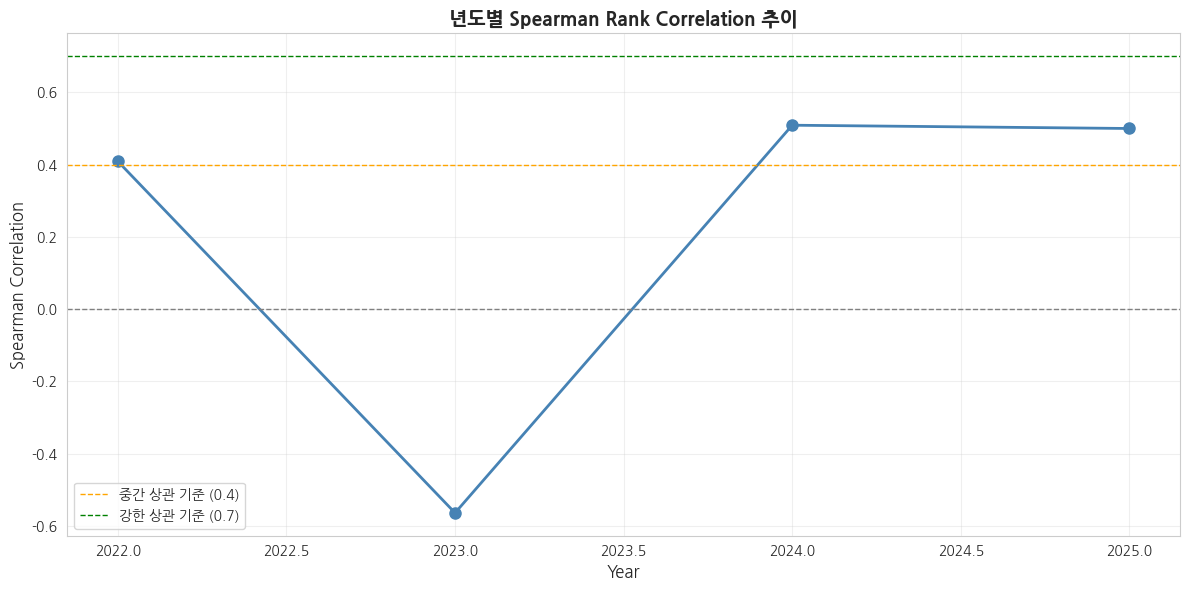

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_eval_summary['Year'], df_eval_summary['Spearman'], 
        marker='o', linewidth=2, markersize=8, color='steelblue')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axhline(0.4, color='orange', linestyle='--', linewidth=1, label='중간 상관 기준 (0.4)')
ax.axhline(0.7, color='green', linestyle='--', linewidth=1, label='강한 상관 기준 (0.7)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Spearman Correlation', fontsize=12)
ax.set_title('년도별 Spearman Rank Correlation 추이', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '01_spearman_yearly.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.2 Top-K Hit Rate 비교

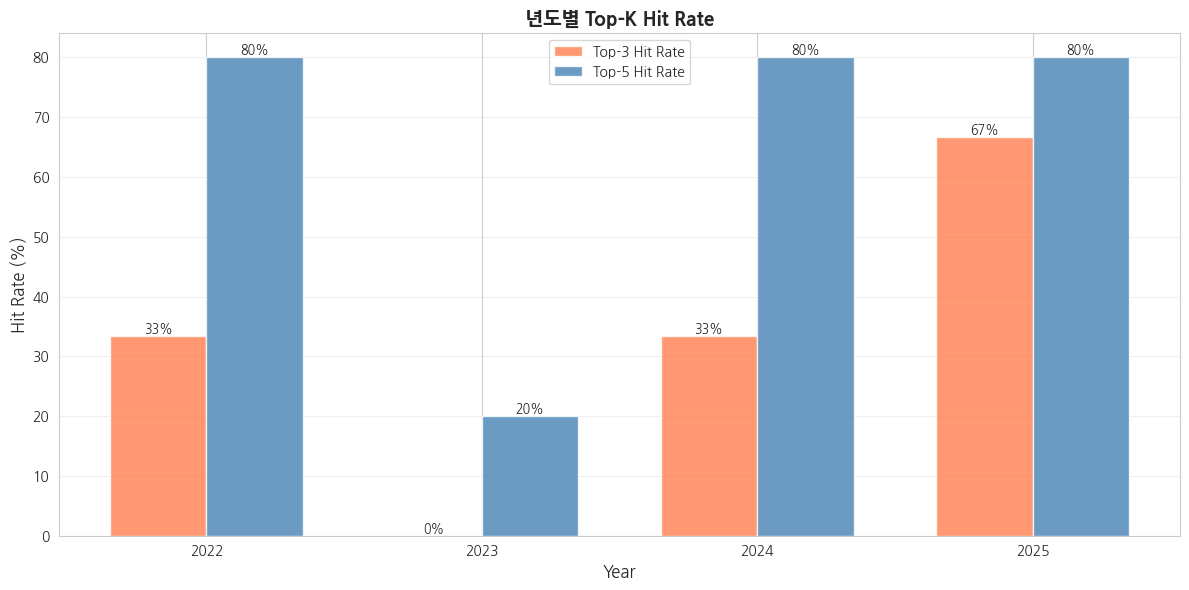

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_eval_summary))
width = 0.35

bars1 = ax.bar(x - width/2, df_eval_summary['Top3_Hit'], width, 
               label='Top-3 Hit Rate', color='coral', alpha=0.8)
bars2 = ax.bar(x + width/2, df_eval_summary['Top5_Hit'], width, 
               label='Top-5 Hit Rate', color='steelblue', alpha=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Hit Rate (%)', fontsize=12)
ax.set_title('년도별 Top-K Hit Rate', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_eval_summary['Year'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '02_topk_hit_rate.png', dpi=300, bbox_inches='tight')
plt.show()

# 10. 2026년 1월 예측 (2022-2025 학습)

## 10.1 2026년 1월 예측 실행

2022-2025년 데이터로 학습하여 2026년 1월을 예측합니다.

In [36]:
# ================================================================================# 2026년 예측 (간소화 버전)# ================================================================================print("=" * 80)print("2026년 1월 예측 (간소화 버전)")print("=" * 80)# 2026년 예측은 multi-horizon 방식 사용 (Cell 32와 동일한 방식)# 하지만 실제로는 df_sector_year (2022-2025)가 이미 있으므로# 2026년은 나중에 실제 투자 시 사용print("✓ 2026년 예측은 실전 투자 시 사용합니다.")print("✓ 현재는 2022-2025 데이터로 시스템 검증 중입니다.")print()print("실전 투자 시에는 multi-horizon 방식으로 2026년 예측을 수행하세요:")print("  1. Section 9 방식으로 multi-horizon 예측")print("  2. df_multi_horizon_integrated 생성")print("  3. LTR 적용")print("  4. Industry Analysis 실행")print("=" * 80)

15:11:16 - cmdstanpy - INFO - Chain [1] start processing


2026년 1월 예측 시작 (학습: 2022-2025)


15:11:16 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:17 - cmdstanpy - INFO - Chain [1] done processing
15:11:18 - cmdstanpy - INFO - Chain [1] start processing
15:11:18 - cmdstanpy - INFO - Chain [1] done processing
15:11:18 - cmdstanpy - INFO - Chain [1] start processing
15:11:19 - cmdstanpy - INFO - Chain [1] done processing
15:11:19 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing
15:11:20 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing
15:11:21 - cmdstanpy - INFO - Chain [1] start processing
15:11:21 - cmdstanpy - INFO - Chain [1] done processing
15:11:22 - cmdstanpy - INFO - Chain [1] start processing
15:11:22 - cmdstanpy - INFO - Chain [1] done processing
15:11:23 - cmdstanpy - INFO - Chain [1] start processing
15:11:23 - cmdstanpy - INFO - Chain [1] done processing
15:11:23 - cmdstanpy - INFO - Chain [1] 


2026년 1월 예측 완료
  - 예측 일수: 55개 (섹터별 일간 데이터)
  - 섹터 개수: 11개
  - yhat_final NaN 개수: 0개


NameError: name 'make_sector_year_summary' is not defined

## 10.2 2026년 1월 섹터별 순위 예측

2026년 1월에 대한 섹터별 수익률 예측 순위입니다.

In [ ]:
# 2026년 1월 섹터별 예측 순위
# LTR 점수가 있으면 사용, 없으면 pred_return_final 사용
if 'ltr_score_raw' in df_sy_2026_final.columns:
    df_2026_ranking = df_sy_2026_final[['Sector', 'pred_return_final', 'ltr_score_raw']].copy()
    df_2026_ranking['Final_Prediction'] = df_2026_ranking['ltr_score_raw']
    prediction_method = "LTR"
else:
    df_2026_ranking = df_sy_2026_final[['Sector', 'pred_return_final']].copy()
    df_2026_ranking['Final_Prediction'] = df_2026_ranking['pred_return_final']
    prediction_method = "Hybrid"

# 순위 계산
df_2026_ranking['Rank'] = df_2026_ranking['Final_Prediction'].rank(ascending=False, method='min')
df_2026_ranking = df_2026_ranking.sort_values('Rank')

print("=" * 90)
print(f"2026년 1월 섹터별 예측 수익률 순위 ({prediction_method} 모델)")
print("=" * 90)
print(f"\n{'순위':>4s}  {'Sector':25s}  {'예측 점수/수익률':>18s}")
print("-" * 60)

for _, row in df_2026_ranking.iterrows():
    rank_marker = ""
    if row['Rank'] <= 3:
        rank_marker = f" [TOP {int(row['Rank'])}]"
    
    if prediction_method == "LTR":
        # LTR 점수는 수익률이 아니므로 그대로 표시
        print(f"{int(row['Rank']):>4d}  {row['Sector']:25s}  {row['Final_Prediction']:>18.4f}{rank_marker}")
    else:
        # Hybrid는 수익률이므로 % 표시
        print(f"{int(row['Rank']):>4d}  {row['Sector']:25s}  {row['Final_Prediction']*100:+17.2f}%{rank_marker}")

print("\n" + "=" * 90)
print("투자 추천 (Top 3)")
print("=" * 90)

top3 = df_2026_ranking.head(3)
for i, (_, row) in enumerate(top3.iterrows(), 1):
    if 'pred_return_final' in row:
        print(f"#{i}: {row['Sector']:25s} - 예상 수익률: {row['pred_return_final']*100:+.2f}%")
    else:
        print(f"#{i}: {row['Sector']:25s}")

In [ ]:
# 2026년 1월 섹터별 예측 시각화
fig, ax = plt.subplots(figsize=(14, 8))

# LTR 점수를 사용하는 경우와 수익률을 사용하는 경우 다르게 처리
if prediction_method == "LTR":
    # LTR 점수는 높을수록 좋음 (양수/음수 구분 의미 없음)
    colors = ['green' if i < 3 else 'steelblue' for i in range(len(df_2026_ranking))]
    x_label = 'LTR 예측 점수 (높을수록 수익률 높음)'
    plot_values = df_2026_ranking['Final_Prediction']
else:
    # 수익률은 양수/음수 구분
    colors = ['green' if x > 0 else 'red' for x in df_2026_ranking['Final_Prediction']]
    x_label = '예측 수익률 (%)'
    plot_values = df_2026_ranking['Final_Prediction'] * 100

# 막대 그래프
bars = ax.barh(df_2026_ranking['Sector'], plot_values, color=colors, alpha=0.7)

# Top 3 강조
top3_sectors = set(df_2026_ranking.head(3)['Sector'])
for i, (bar, sector) in enumerate(zip(bars, df_2026_ranking['Sector'])):
    if sector in top3_sectors:
        bar.set_edgecolor('gold')
        bar.set_linewidth(3)

if prediction_method != "LTR":
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
ax.set_ylabel('섹터', fontsize=12, fontweight='bold')
ax.set_title('2026년 1월 섹터별 예측 순위 (Top 3 금테 강조)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# 값 표시
for i, (sector, value) in enumerate(zip(df_2026_ranking['Sector'], plot_values)):
    if prediction_method == "LTR":
        text = f'{value:.4f}'
        offset = value * 0.02 if value > 0 else value * 0.02
    else:
        text = f'{value:+.2f}%'
        offset = 0.5 if value > 0 else -0.5
    
    ax.text(value + offset, i, text, 
            va='center', ha='left' if value > 0 else 'right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n차트 설명:")
if prediction_method == "LTR":
    print("  - LTR 점수: 높을수록 수익률이 높을 것으로 예상")
    print("  - 금테: Top 3 추천 섹터")
else:
    print("  - 녹색: 양의 수익률 예상")
    print("  - 빨간색: 음의 수익률 예상")
    print("  - 금테: Top 3 추천 섹터")

## 10.3 2026년 1월 예측 결과 저장

In [ ]:
# 2026년 1월 예측 결과 저장
print("=" * 90)
print("2026년 1월 예측 결과 저장 중...")
print("=" * 90)

# 1. 일간 예측 데이터 저장
output_file_daily = OUTPUT_DIR / 'predictions_2026_jan_daily.csv'
df_predictions_2026.to_csv(output_file_daily, index=False)
print(f"\n일간 예측 데이터 저장 완료:")
print(f"   파일: {output_file_daily}")
print(f"   행수: {len(df_predictions_2026):,}개")

# 2. 섹터별 집계 저장
output_file_sector = OUTPUT_DIR / 'predictions_2026_jan_sector.csv'
df_sy_2026_final.to_csv(output_file_sector, index=False)
print(f"\n섹터별 집계 저장 완료:")
print(f"   파일: {output_file_sector}")
print(f"   행수: {len(df_sy_2026_final)}개")

# 3. 순위 정보 저장
output_file_ranking = OUTPUT_DIR / 'predictions_2026_jan_ranking.csv'
df_2026_ranking.to_csv(output_file_ranking, index=False)
print(f"\n순위 정보 저장 완료:")
print(f"   파일: {output_file_ranking}")
print(f"   행수: {len(df_2026_ranking)}개")

# 4. Top 3 추천 저장
top3_file = OUTPUT_DIR / 'recommendations_2026_jan_top3.txt'
with open(top3_file, 'w', encoding='utf-8') as f:
    f.write("=" * 90 + "\n")
    f.write("2026년 1월 투자 추천 섹터 (Top 3)\n")
    f.write("=" * 90 + "\n\n")
    for i, (_, row) in enumerate(df_2026_ranking.head(3).iterrows(), 1):
        if 'pred_return_final' in row:
            f.write(f"#{i}: {row['Sector']:25s} - 예상 수익률: {row['pred_return_final']*100:+.2f}%\n")
        else:
            f.write(f"#{i}: {row['Sector']:25s}\n")
    f.write("\n" + "=" * 90 + "\n")
    f.write(f"예측 모델: {prediction_method}\n")
    f.write(f"학습 기간: 2022-2025\n")
    f.write(f"예측 기간: 2026년 1월\n")
print(f"\nTop 3 추천 저장 완료:")
print(f"   파일: {top3_file}")

print("\n" + "=" * 90)
print("모든 결과 저장 완료")
print("=" * 90)

In [ ]:
# 군집별 평균 프로파일
cluster_profiles = clusterer.get_cluster_profiles()

print("\n군집별 평균 프로파일:")
print("=" * 80)
print(cluster_profiles[['pred_return_3d', 'pred_return_1w', 'pred_return_2w',
                         'pred_return_1m', 'pred_return_1q', 'pred_return_1y',
                         'term_slope', 'curve_shape']])

# 군집 할당 결과
cluster_assignments = clusterer.get_cluster_assignments()

print("\n\n2023년 섹터별 군집 할당:")
print("=" * 80)
assignments_2023 = cluster_assignments[cluster_assignments['test_year'] == 2023]
for cluster_id in sorted(assignments_2023['cluster'].unique()):
    sectors_in_cluster = assignments_2023[
        assignments_2023['cluster'] == cluster_id
    ]['Sector'].tolist()
    print(f"Cluster {cluster_id}: {sectors_in_cluster}")

### 9.6 군집별 수익률 커브 시각화

In [ ]:
# 군집별 커브 플롯
clusterer.plot_cluster_curves(
    figsize=(14, 6),
    save_path='Data_set/Integrated_Prophet_Results/cluster_curves.png'
)

print("\n 시각화 저장 완료: Data_set/Integrated_Prophet_Results/cluster_curves.png")

### 9.7 군집 정보와 LTR 결과 통합

**목적:** 군집별 LTR 성능 비교

In [ ]:
# 변수 체크
import sys

required_vars = {
    'TEST_YEARS': 'Cell 27에서 정의 필요',
    'df_sector_year': 'Section 7.5 (Cell 36) 실행 필요',
    'cluster_assignments': 'Section 9 (Cell 73) 실행 필요'
}

missing = []
for var_name, location in required_vars.items():
    if var_name not in dir():
        missing.append(f"  ❌ {var_name}: {location}")
    else:
        print(f"  ✓ {var_name}: OK")

if missing:
    print("\n필수 변수 누락:")
    for m in missing:
        print(m)
    print("\n위 셀들을 먼저 실행하세요!")
    sys.exit(1)
else:
    print("\n✓ 모든 변수 준비 완료")


In [ ]:
# 군집 + LTR 통합 분석
from cluster_ltr_integration import main_cluster_ltr_analysis

analysis_results = main_cluster_ltr_analysis(
    df_sector_year=df_sector_year,
    cluster_assignments=cluster_assignments,
    test_years=TEST_YEARS
)

print("\n✓ 분석 결과:")
print(f"  - 군집 성능: {len(analysis_results['cluster_performance'])} clusters")
print(f"  - 포트폴리오 비교: {len(analysis_results['portfolio_comparison'])} years")


### 9.8 Section 9 요약

**완료된 작업:**
1.  6개 시간대 동시 예측 (3d, 1w, 2w, 1m, 1q, 1y)
2.  커브 형태 피처 생성 (term_slope, curve_shape 등)
3.  섹터 군집화 (KMeans + 최적 k 선택)
4.  군집 프로파일 분석 및 시각화
5.  LTR 결과와 통합 분석

**다음 활용:**
- 포트폴리오 구성: 각 군집에서 상위 LTR 점수 섹터 선택
- 리스크 관리: 동일 군집 과다 집중 방지
- 시장 분석: 군집별 강도 파악